In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

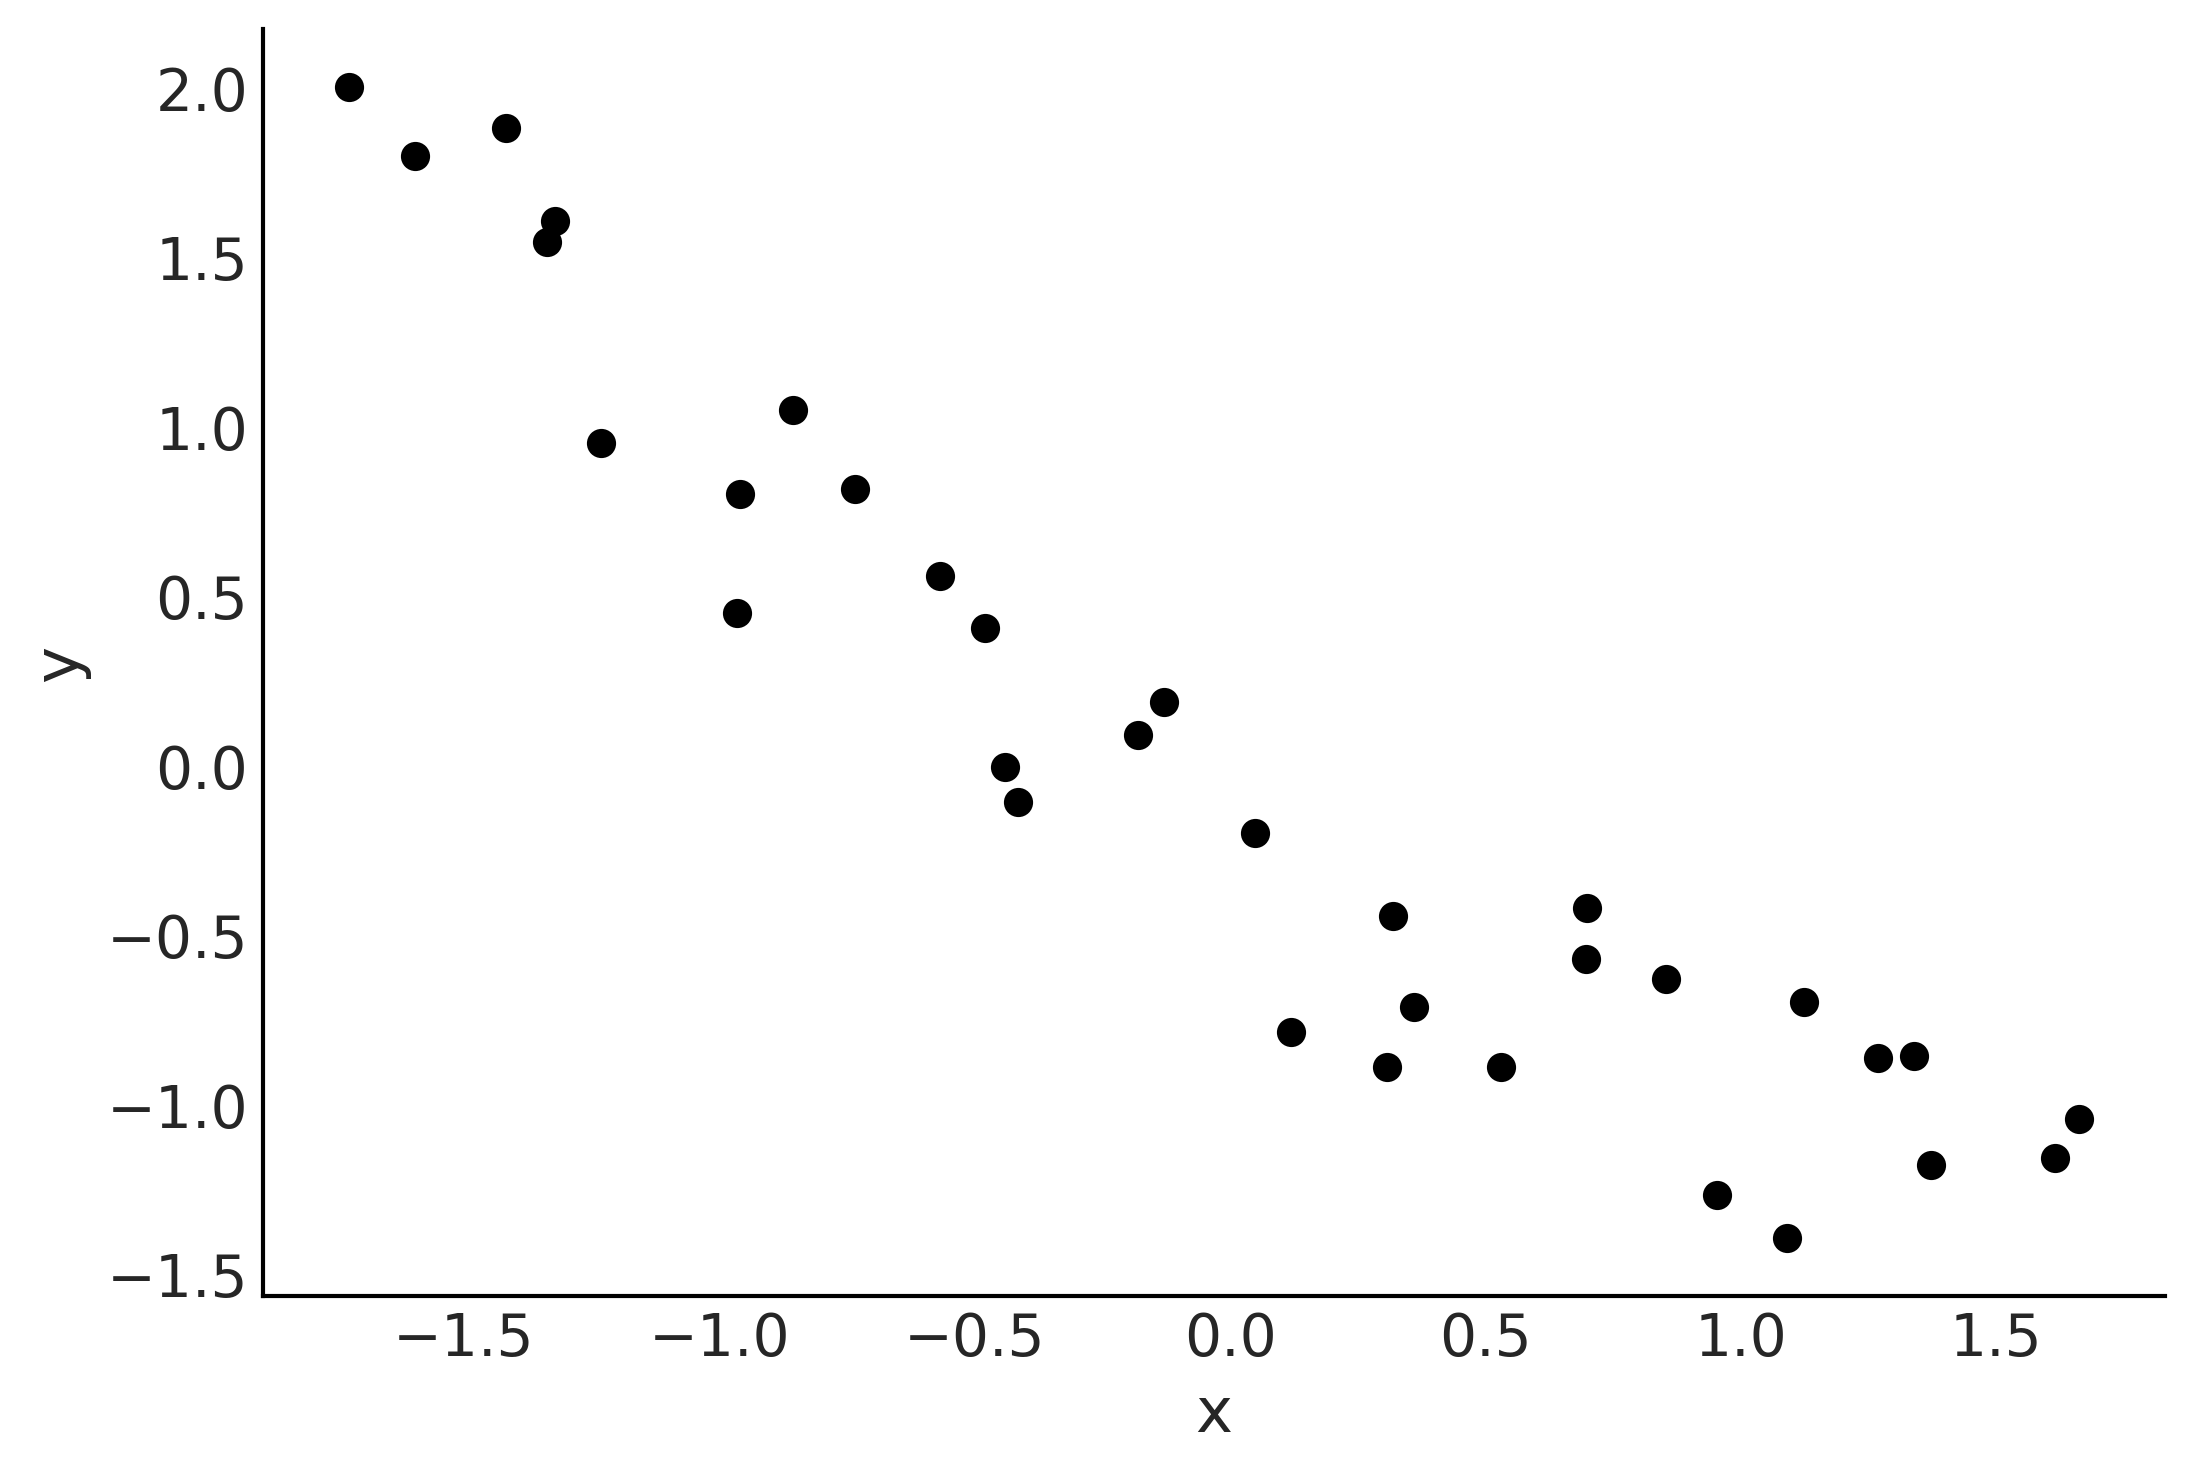

In [3]:
dummy_data = np.loadtxt("data/dummy.csv")
x = dummy_data[:, 0]
y = dummy_data[:, 1]

order = 2
x_p = np.vstack([x**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
plt.scatter(x_c[0], y_c)
plt.xlabel("x")
plt.ylabel("y");

In [4]:
with pm.Model() as model_l:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)

    μ = α + β * x_c[0]

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    idata_l.extend(pm.sample_posterior_predictive(idata_l, random_seed=4591))

with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10, shape=order)
    σ = pm.HalfNormal("σ", 5)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_pred]


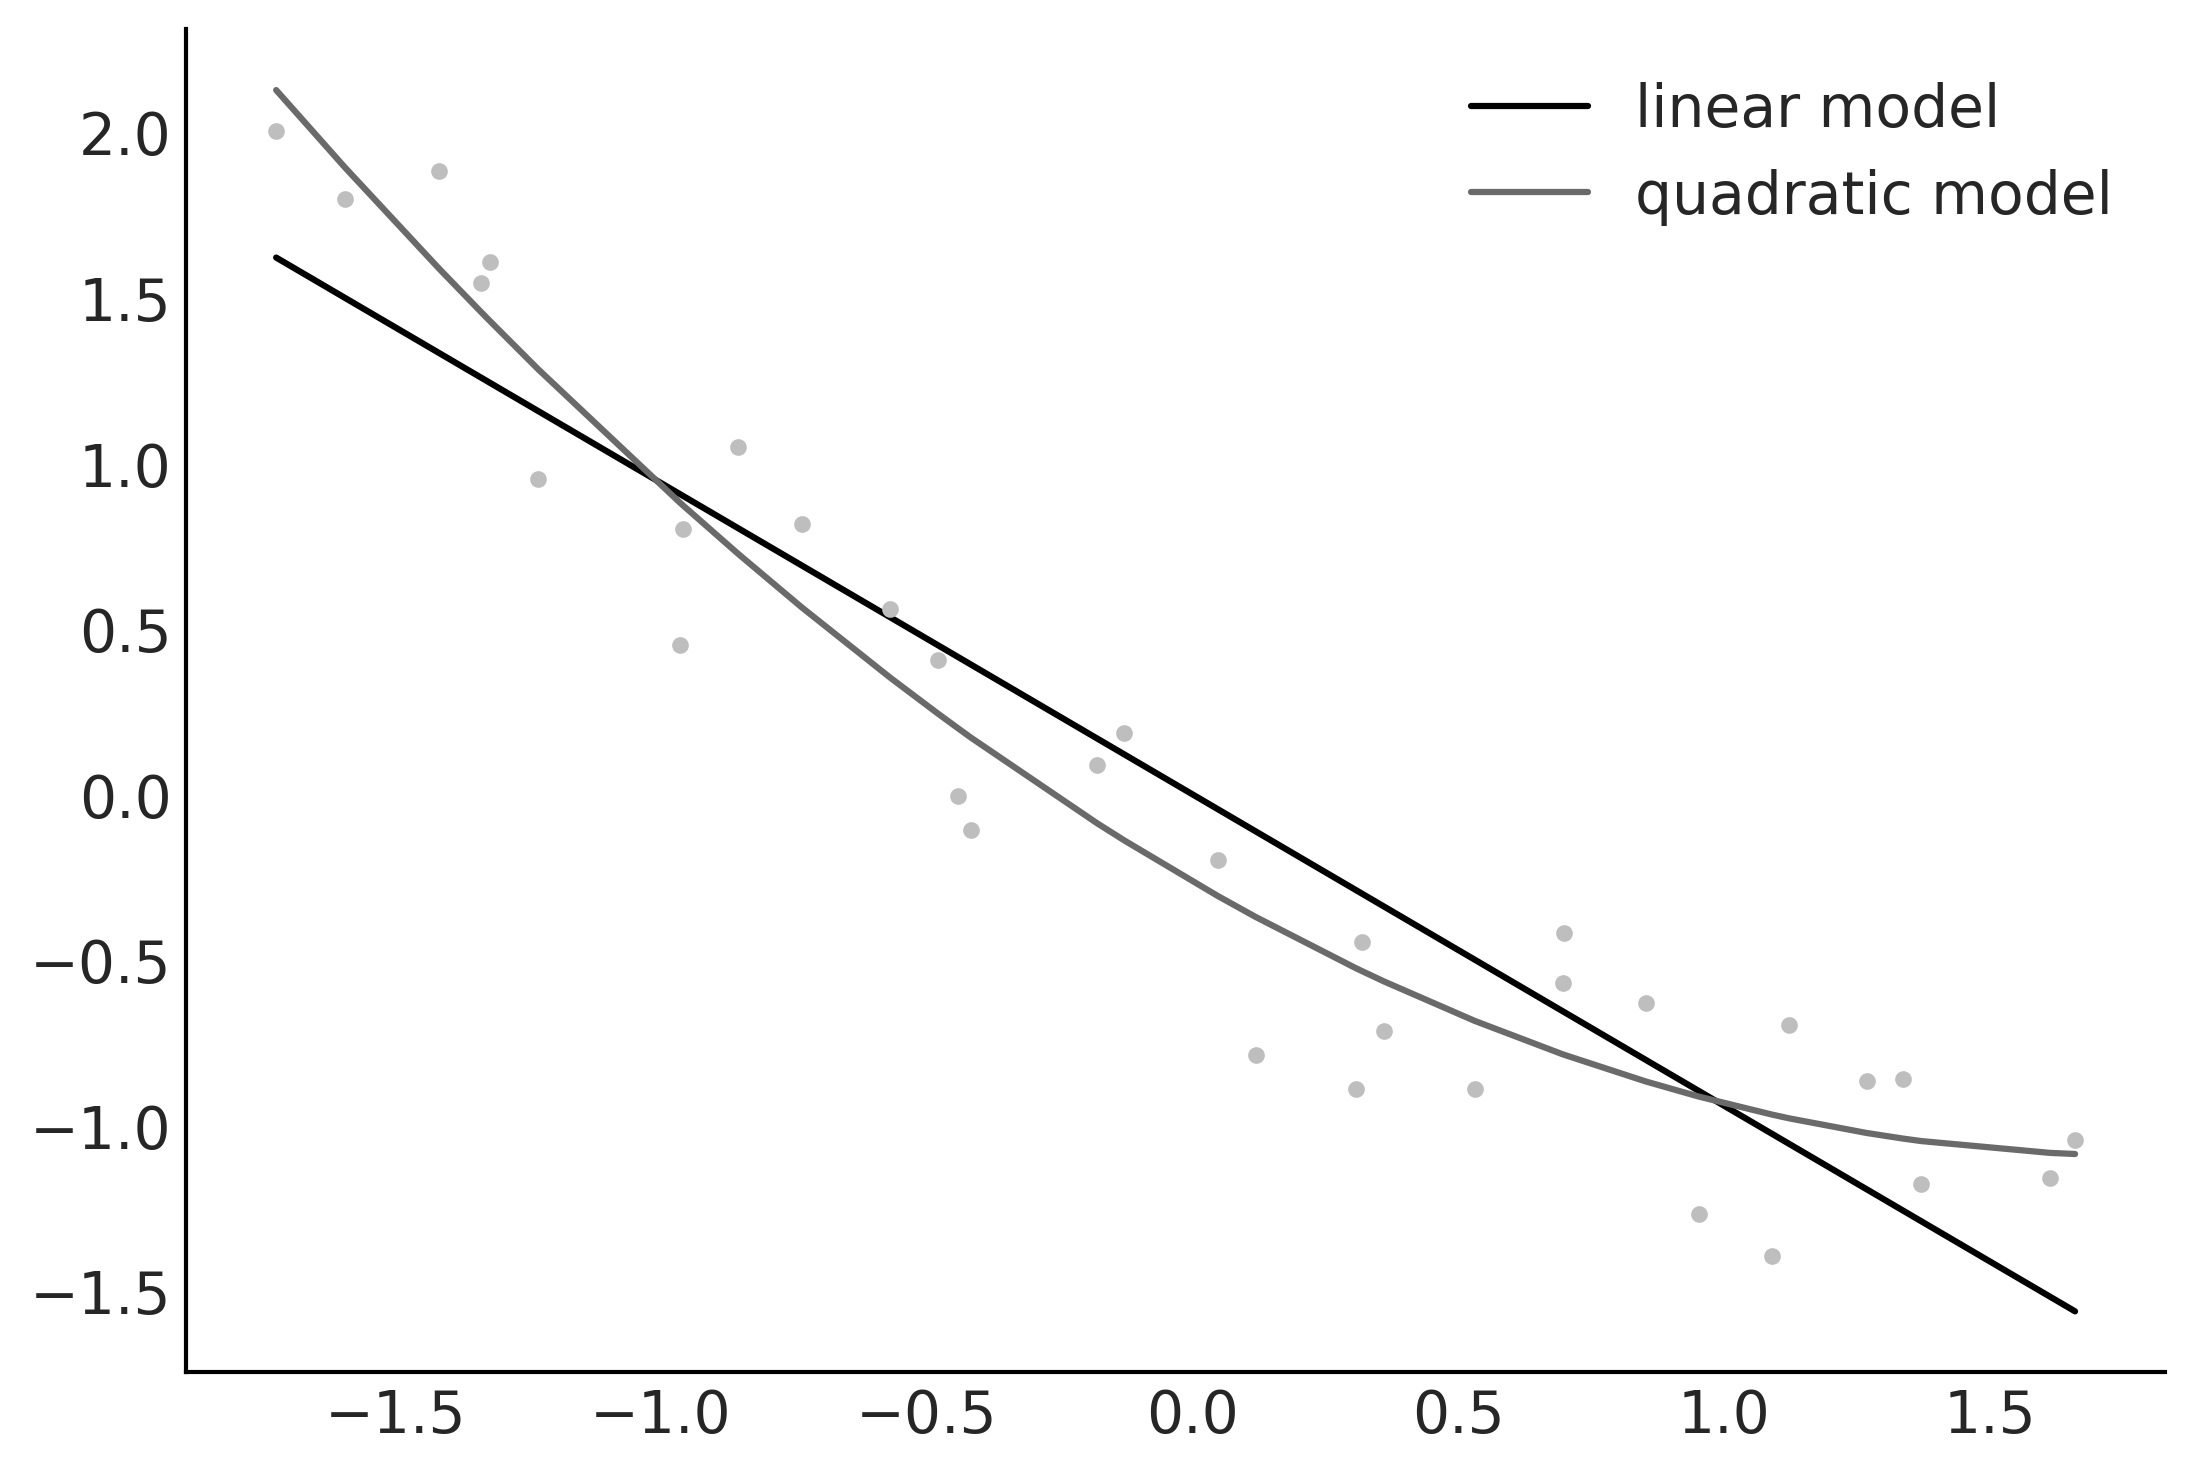

In [5]:
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_q)

α_l_post = posterior_l["α"].mean().item()
β_l_post = posterior_l["β"].mean().item()
y_l_post = α_l_post + β_l_post * x_new

plt.plot(x_new, y_l_post, "C0", label="linear model")

α_p_post = posterior_p["α"].mean().item()
β_p_post = posterior_p["β"].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], "C1", label=f"quadratic model")

plt.plot(x_c[0], y_c, "C2.")
plt.legend()
plt.savefig("../fig/lin-pol-fit.png")

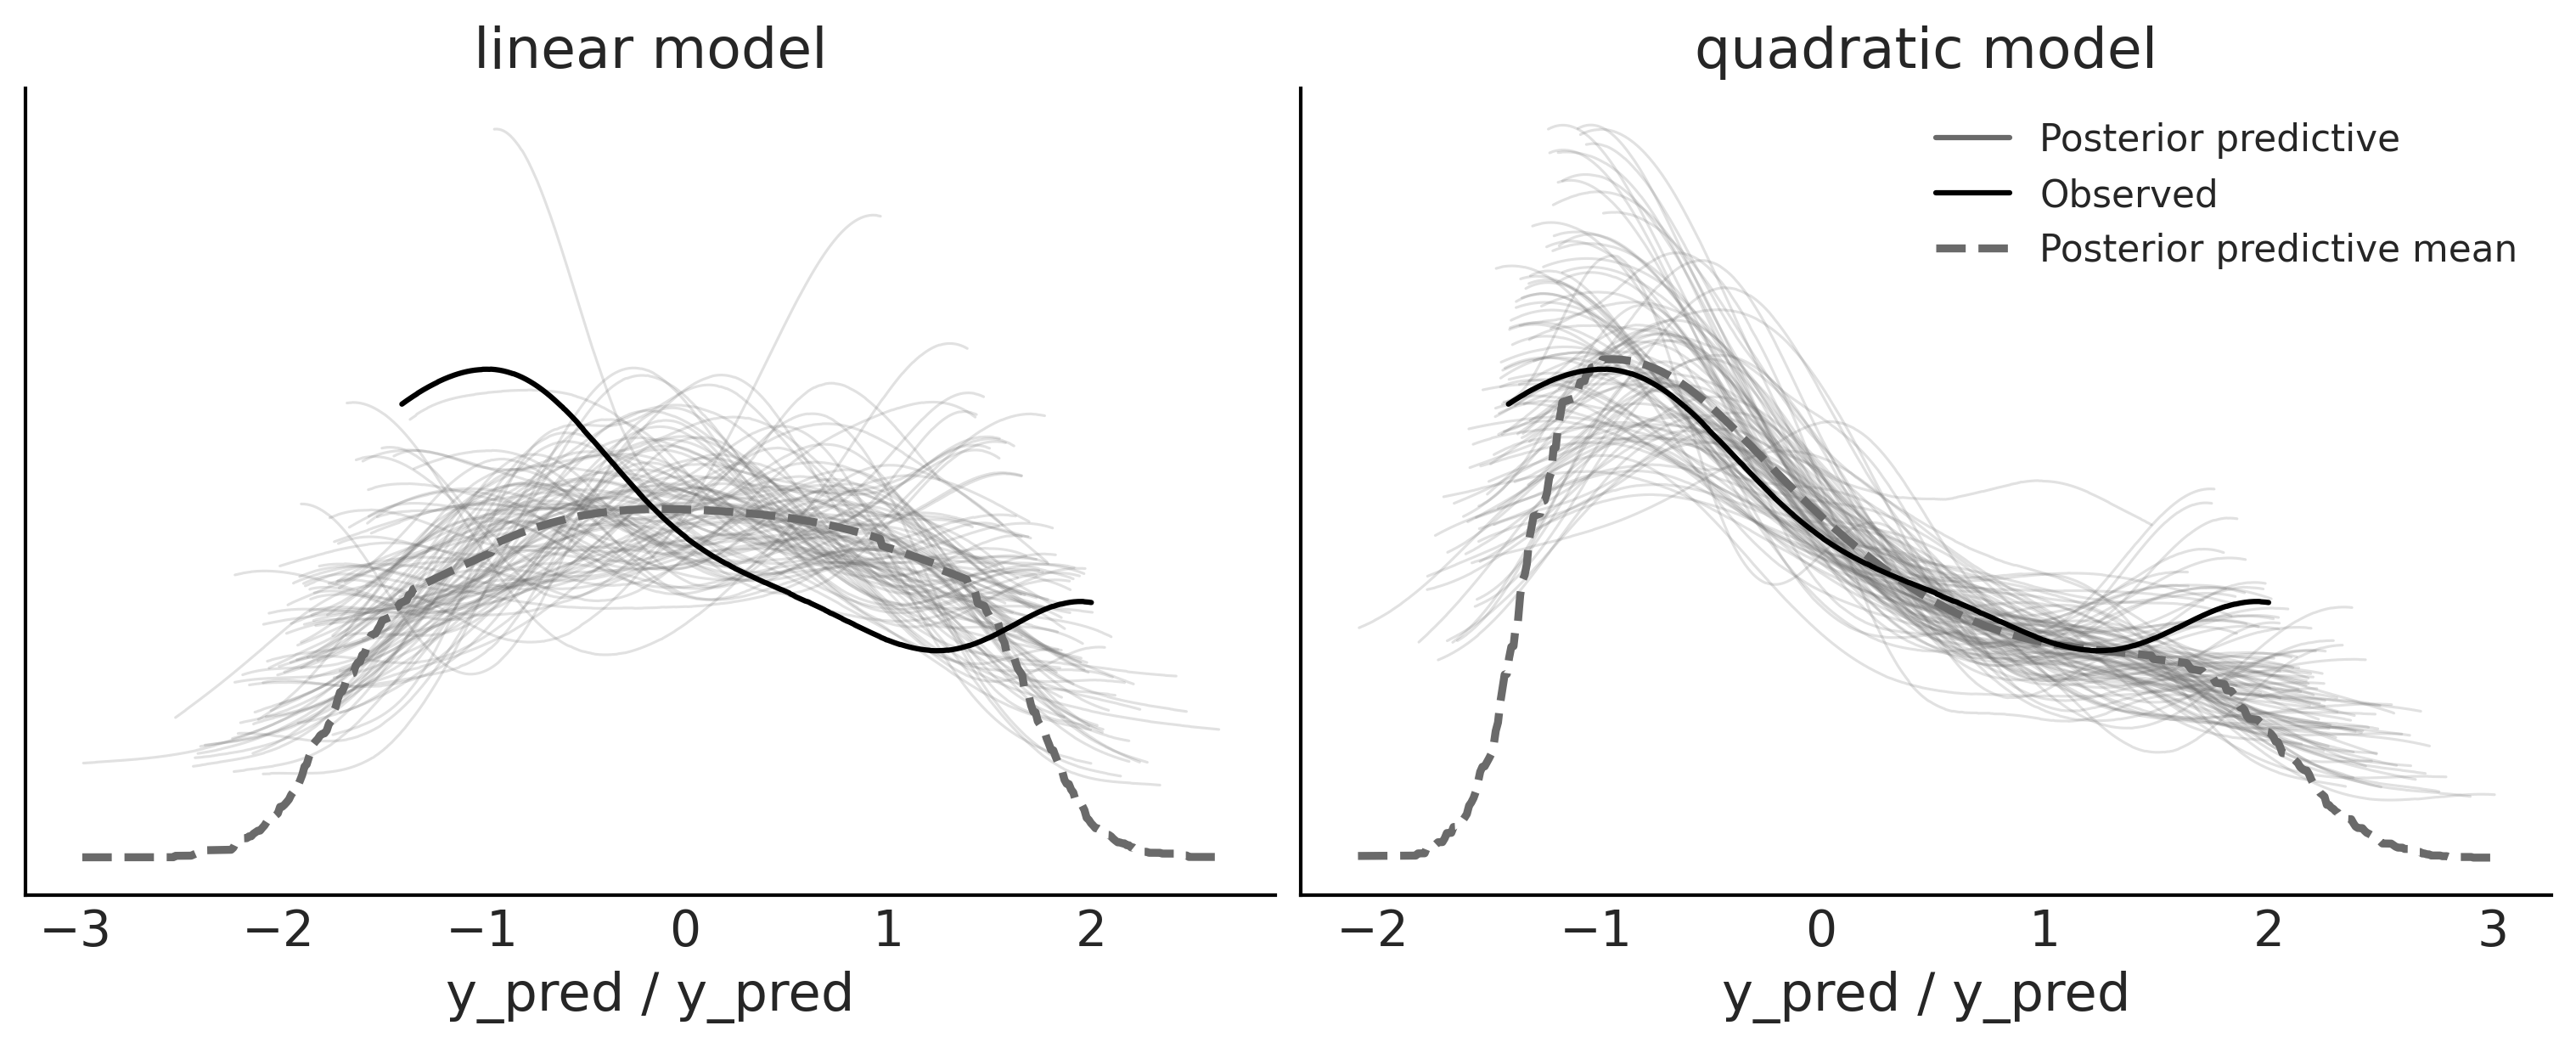

In [6]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model")
az.plot_ppc(idata_q, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"quadratic model")

plt.savefig("../fig/lin-pol-ppc.png")

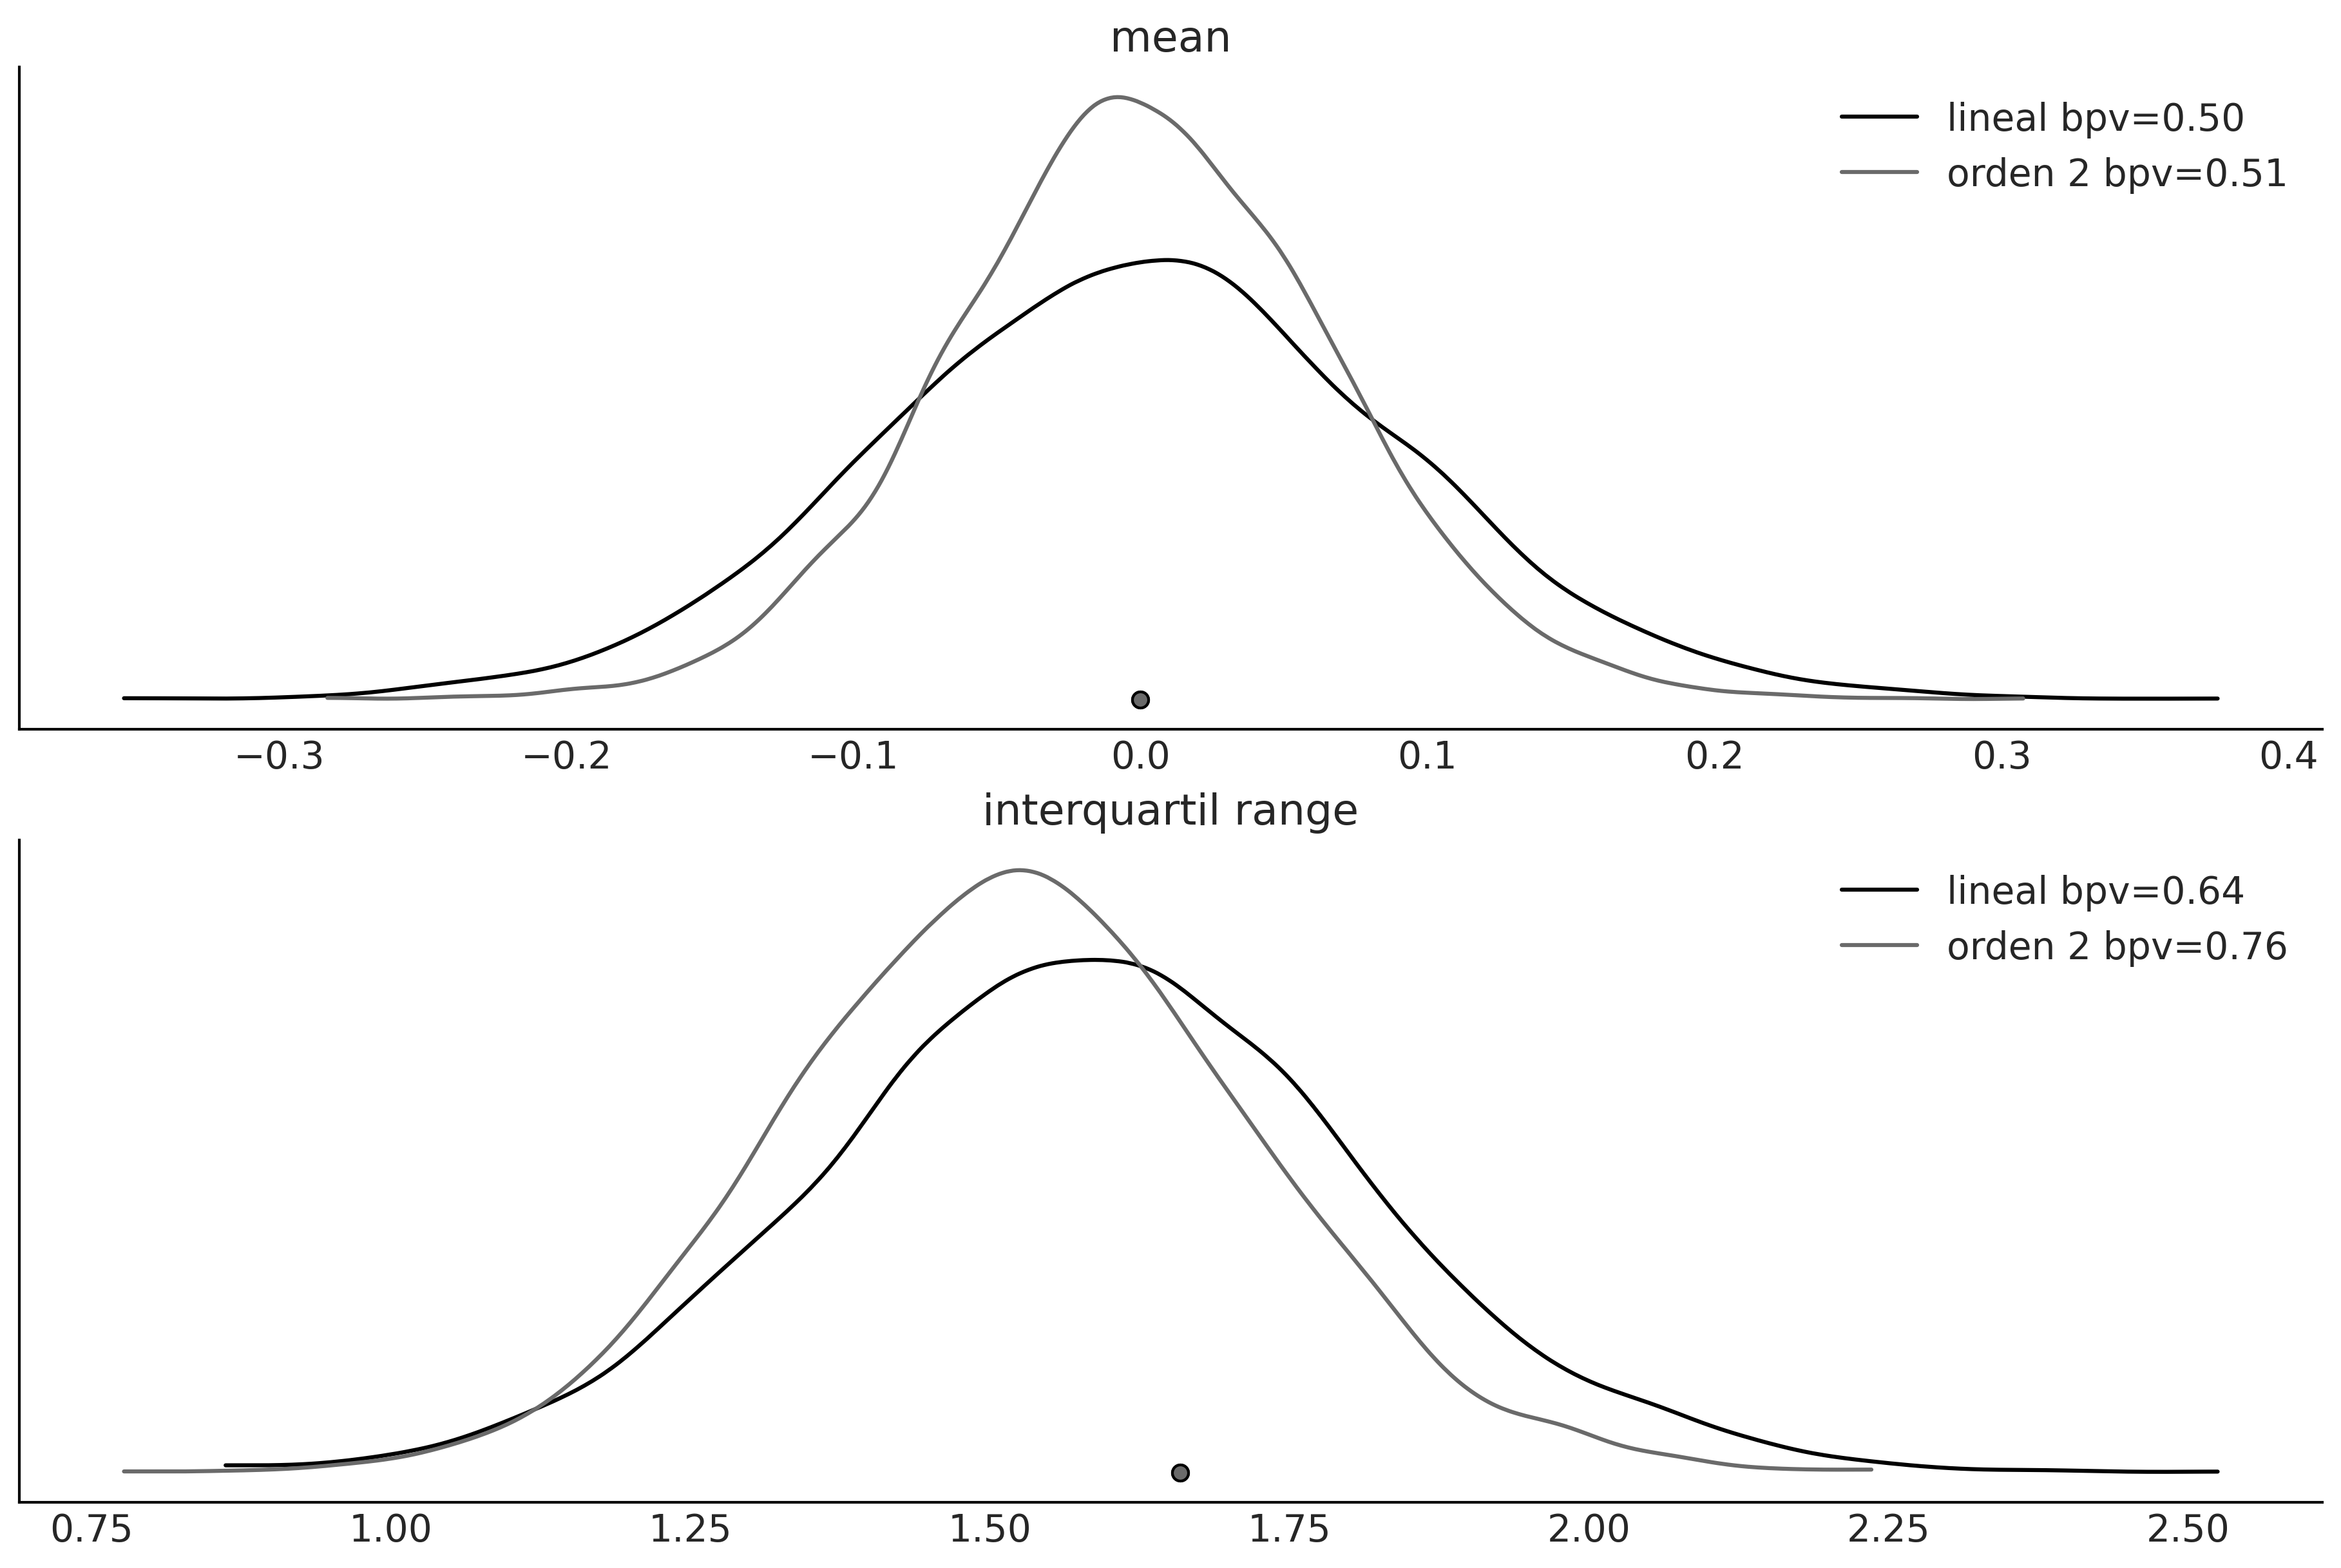

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["mean", "interquartil range"]
modelos = ["lineal", f"orden {order}"]
idatas = [idata_l, idata_q]


def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for (
    ax,
    title,
) in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles[idx]._alpha = 1
        ax.legend_.legend_handles[idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

plt.savefig("../fig/lin-pol-bpv.png")

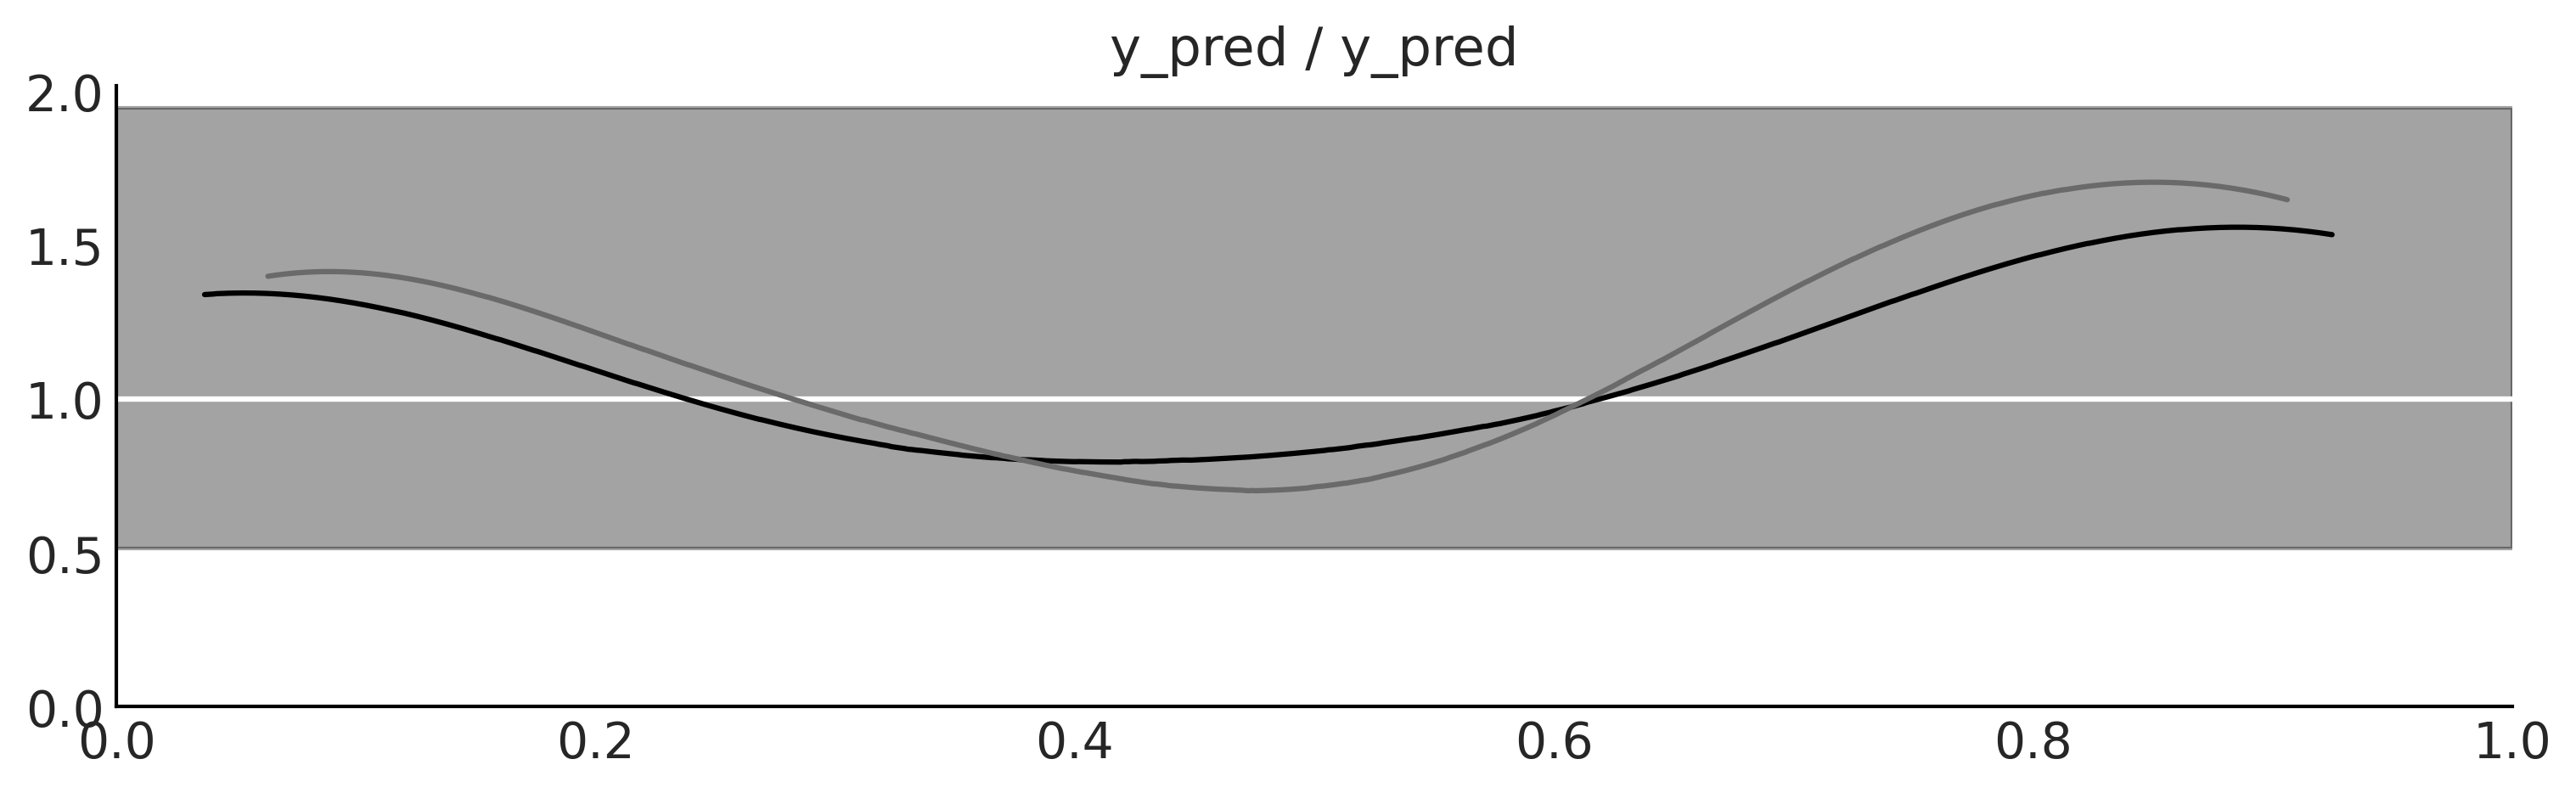

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

plt.savefig("../fig/lin-pol-bpv2.png")

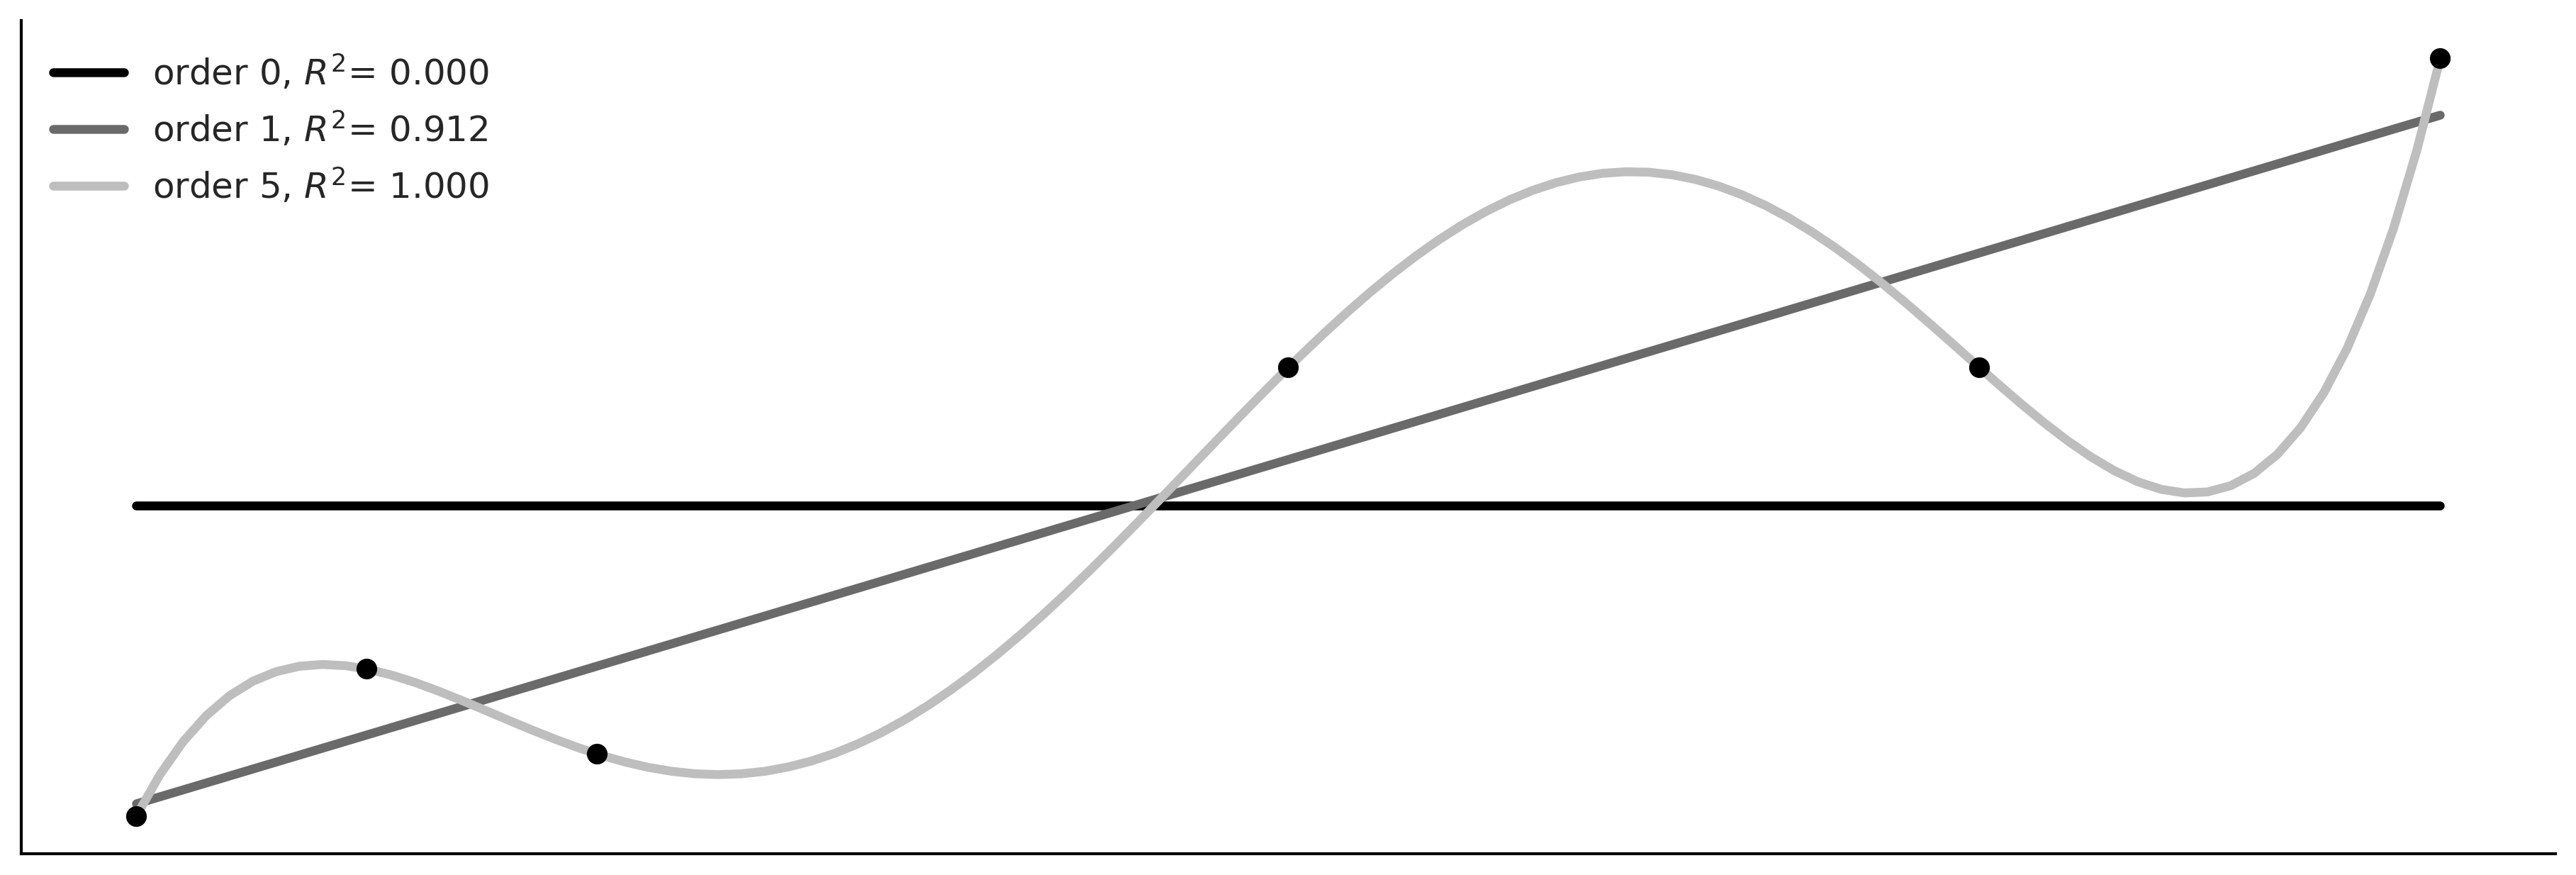

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])

order = [0, 1, 5]
ax.plot(x0, y0, "ko", zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat - y0) ** 2)
    ss_total = np.sum((ybar - y0) ** 2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)


ax.legend(loc=2, fontsize=12)
plt.savefig("../fig/over_under_fit.png")

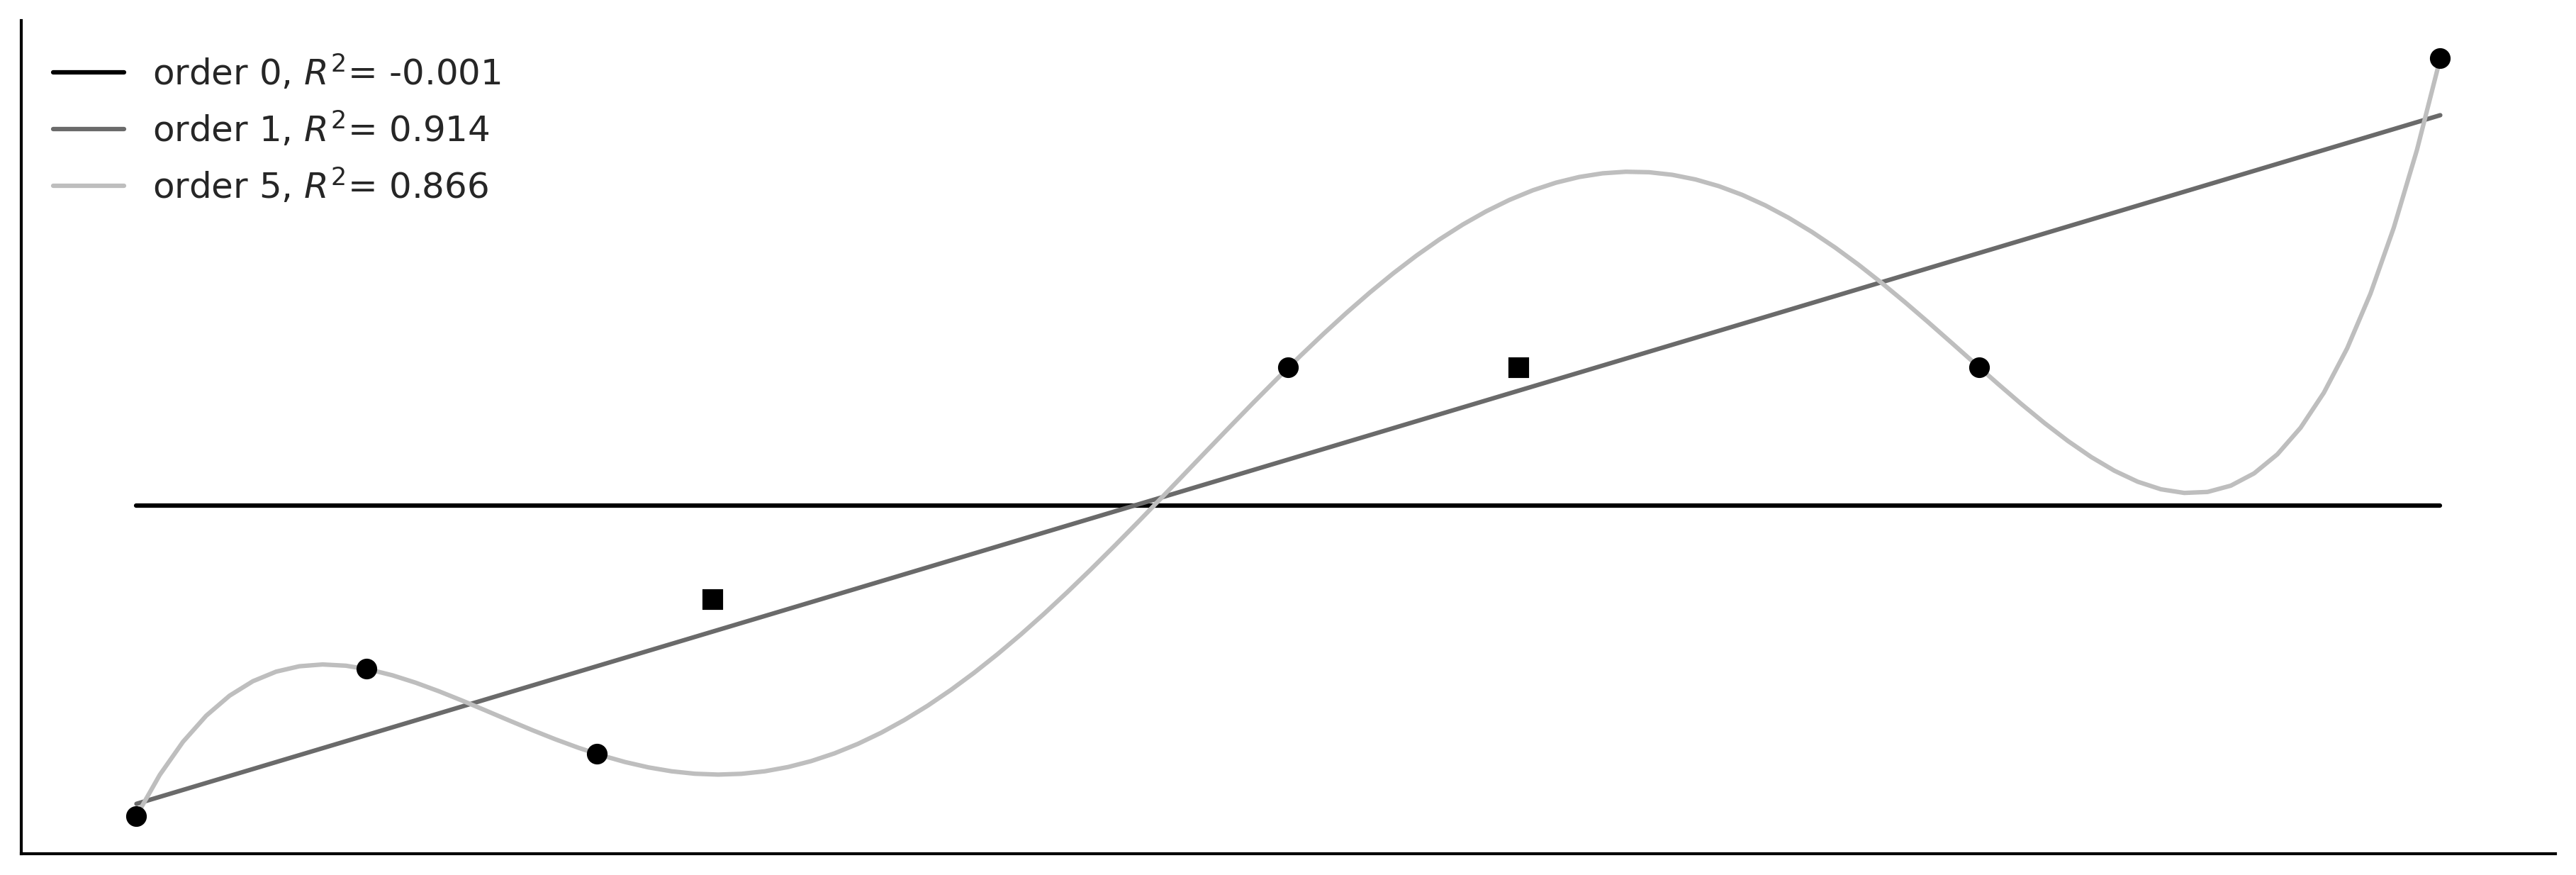

In [10]:
_, ax = plt.subplots(figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, "ko", zorder=3)
ax.plot(x_, y_, "ks", zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat - y1) ** 2)
    ss_total = np.sum((ybar - y1) ** 2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f"order {i}, $R^2$= {r2:.3f}")


ax.legend(loc=2, fontsize=12)

plt.savefig("../fig/over_under_fit2.png")

In [11]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.34     2.66
p_waic        2.43        -

In [12]:
waic_p = az.waic(idata_q)
waic_p

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -4.53     2.33
p_waic        2.61        -

In [13]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.38     2.66
p_loo        2.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
loo_q = az.loo(idata_q)
loo_q

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -4.56     2.33
p_loo        2.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
cmp_df = az.compare({"model_l": idata_l, "model_p": idata_q})
# cmp_df.to_markdown()
cmp_df

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_p,0,-4.563934,2.641476,0.000000,1.000000e+00,2.331137,0.000000,False,log
model_l,1,-14.379238,2.466970,9.815304,1.776357e-13,2.664980,2.679719,False,log


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


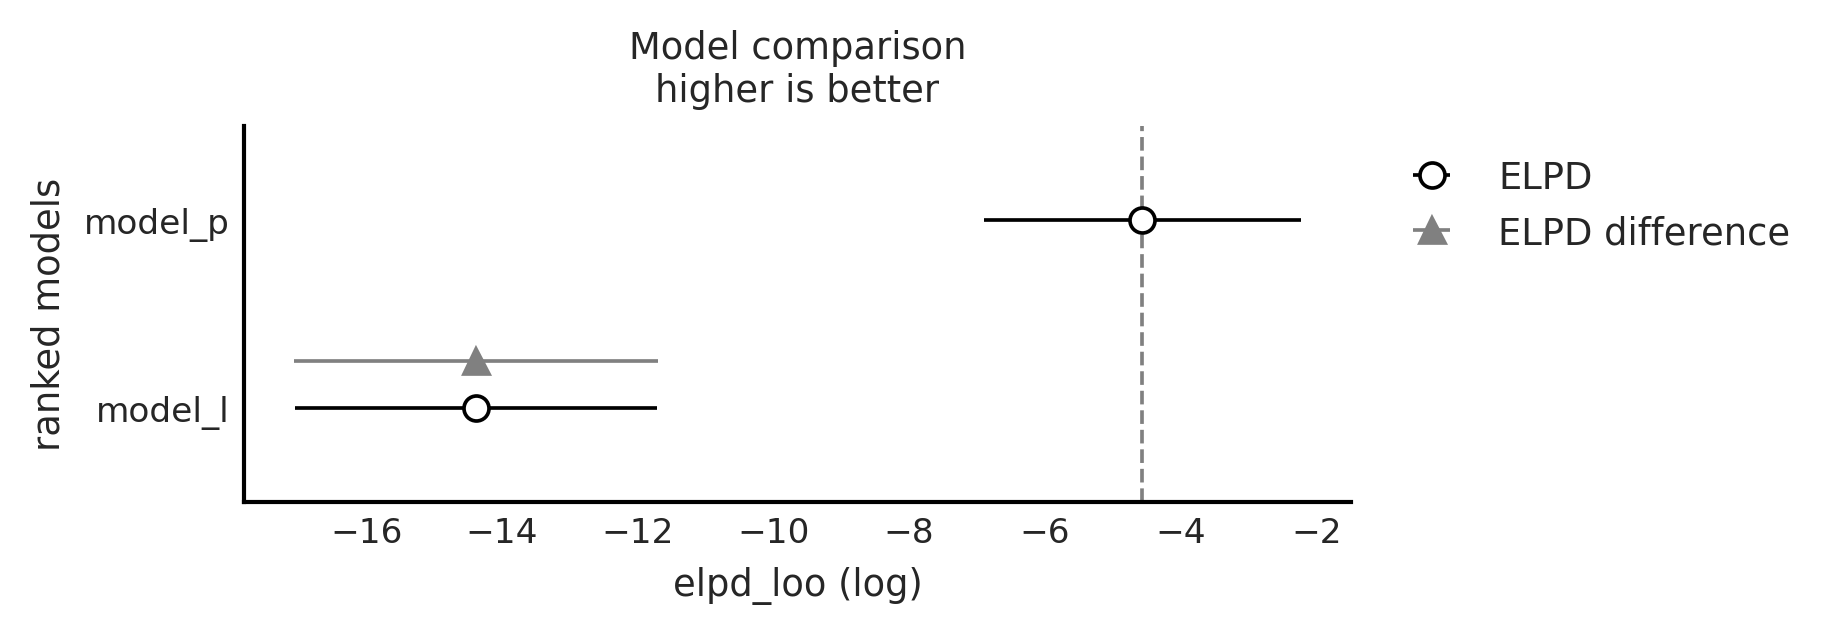

In [16]:
az.plot_compare(cmp_df)
plt.savefig("../fig/compareplot.png")

In [17]:
idata_w = az.weight_predictions(idatas, weights=[0.35, 0.65])

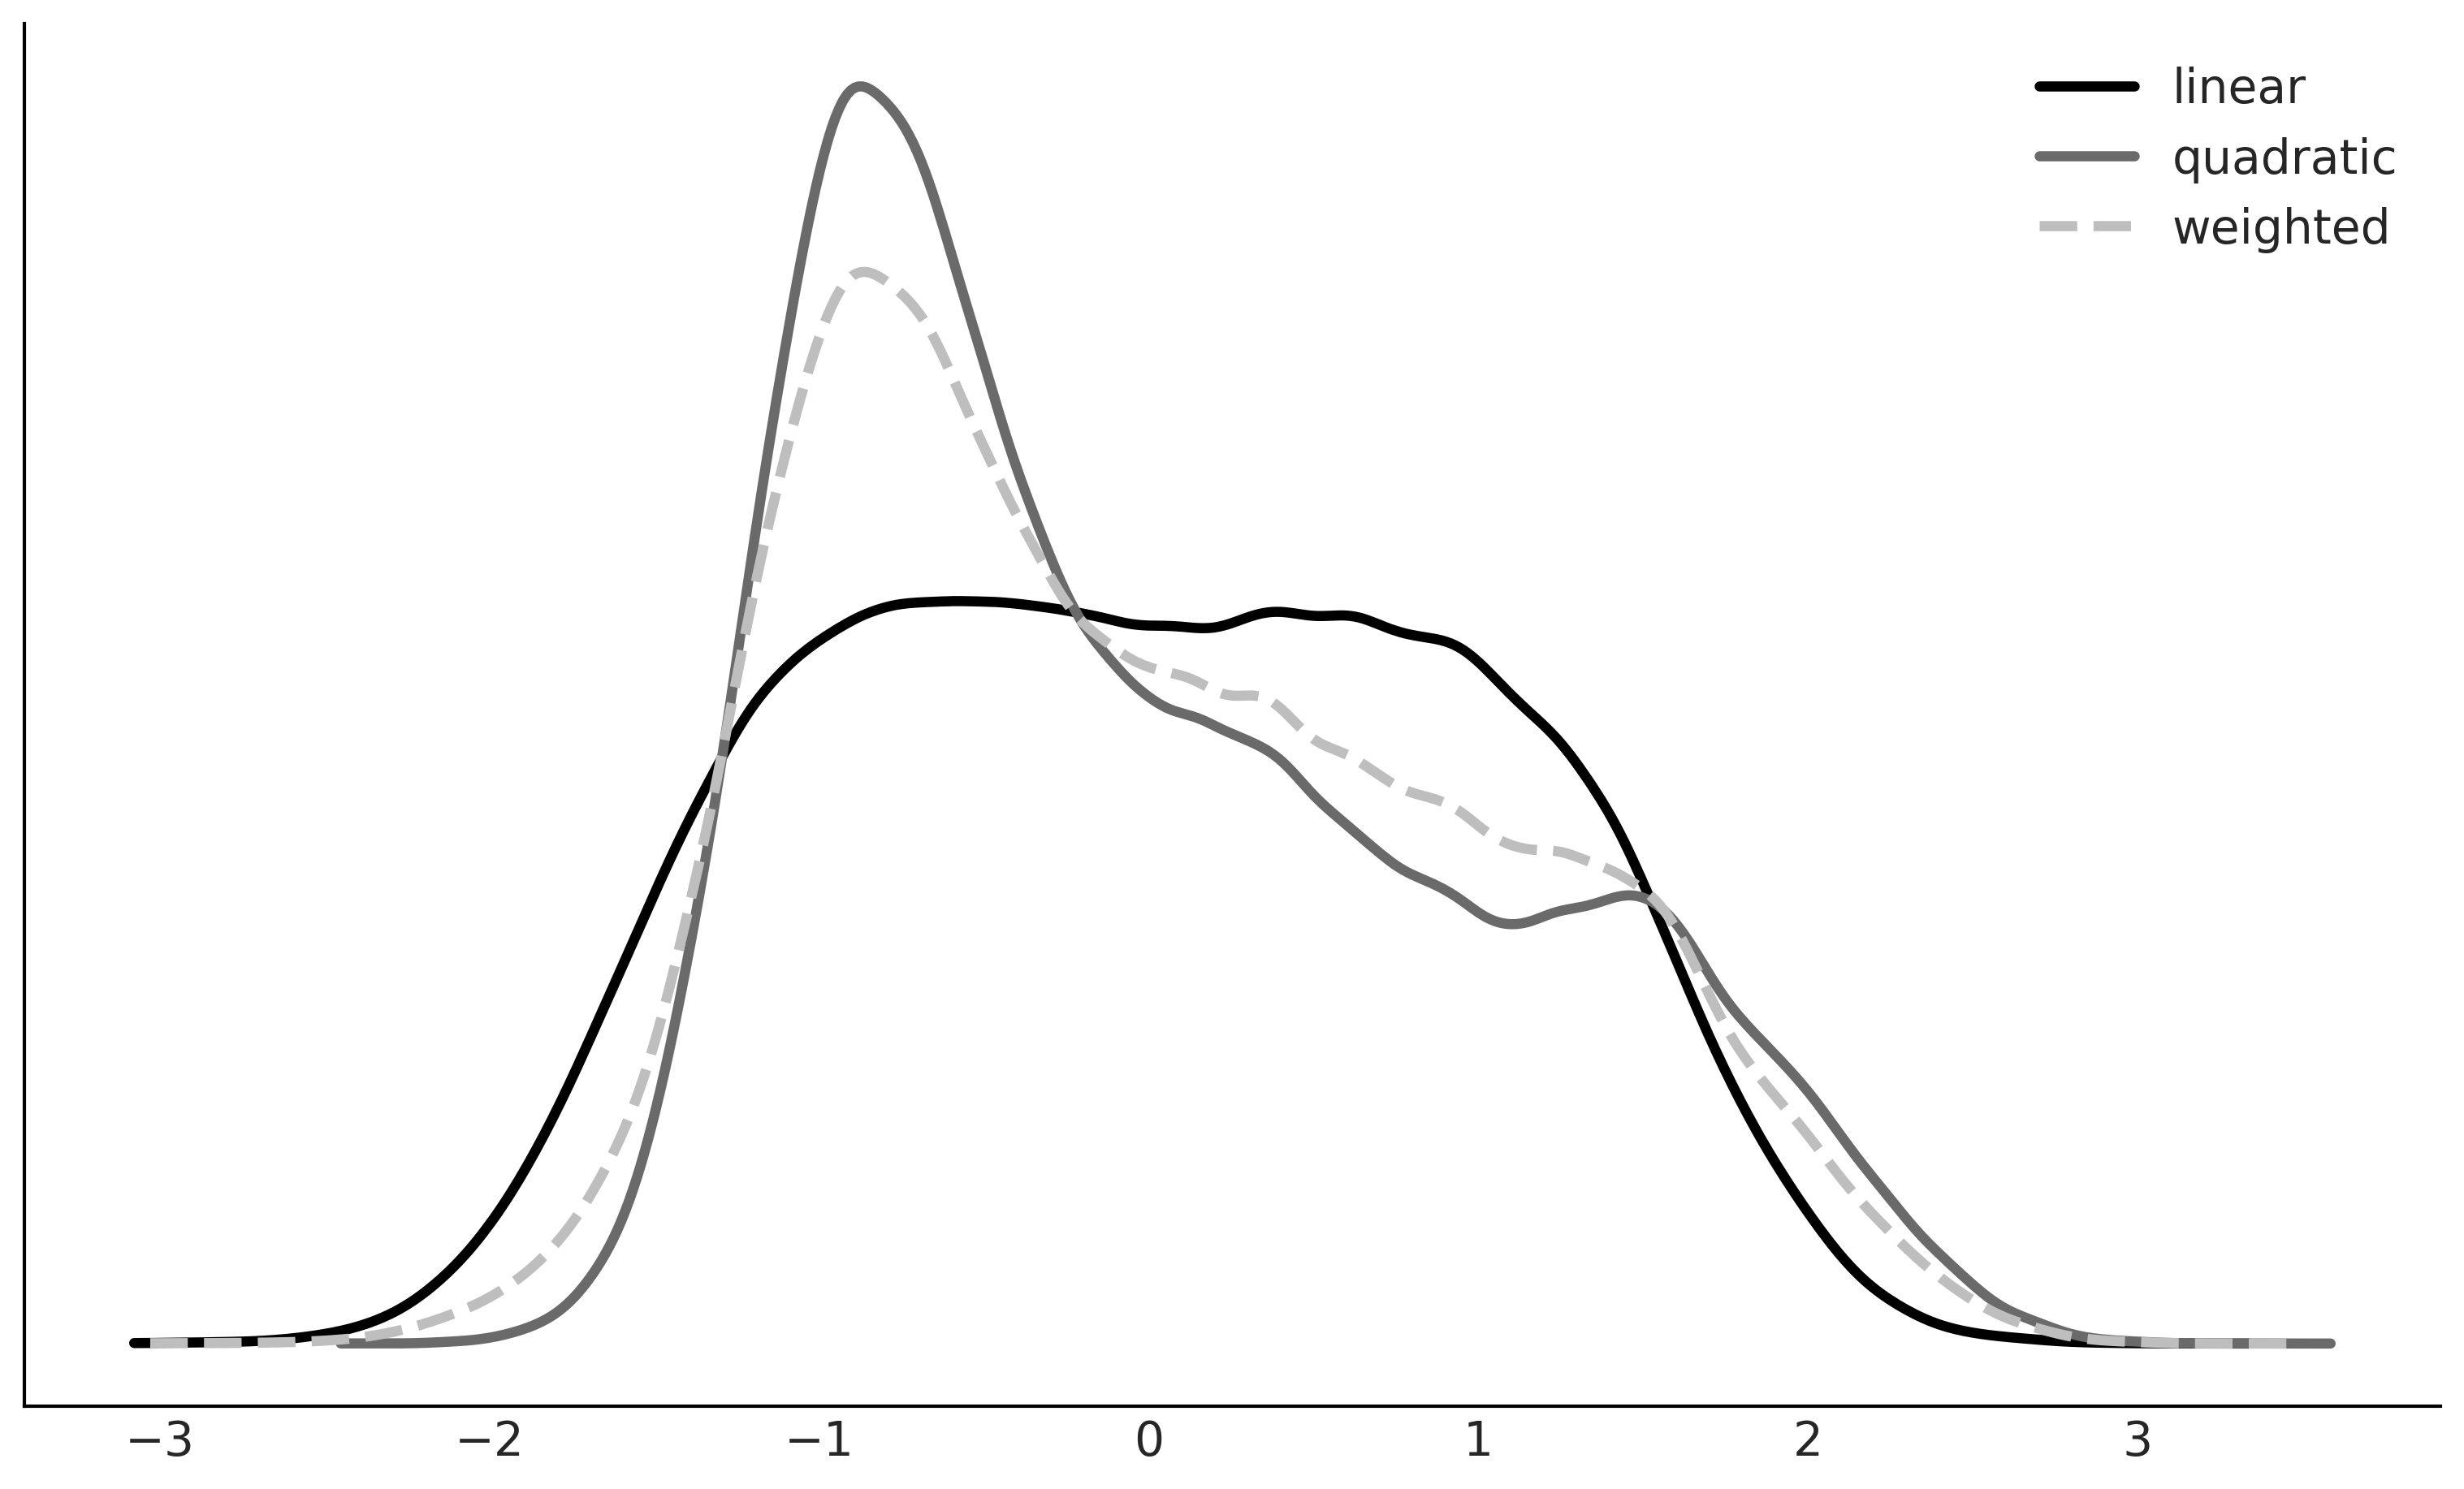

In [18]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_q.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.yticks([])
plt.legend()
plt.savefig("../fig/lin-pol-weighted.png")

In [19]:
def beta_binom(prior, y):
    """
    Calculate the marginal probability, analytically, for a beta-binomial model.
    prior : tuple
      alpha and beta parameters for the beta prior
    y : array
      array with "1" and "0" corresponding to success and failure respectively
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))

    return p_y

In [20]:
y = np.repeat([1, 0], [50, 50])  # 50 heads, 50 tails
priors = ((1, 1), (30, 30))  # uniform prior, peaked prior

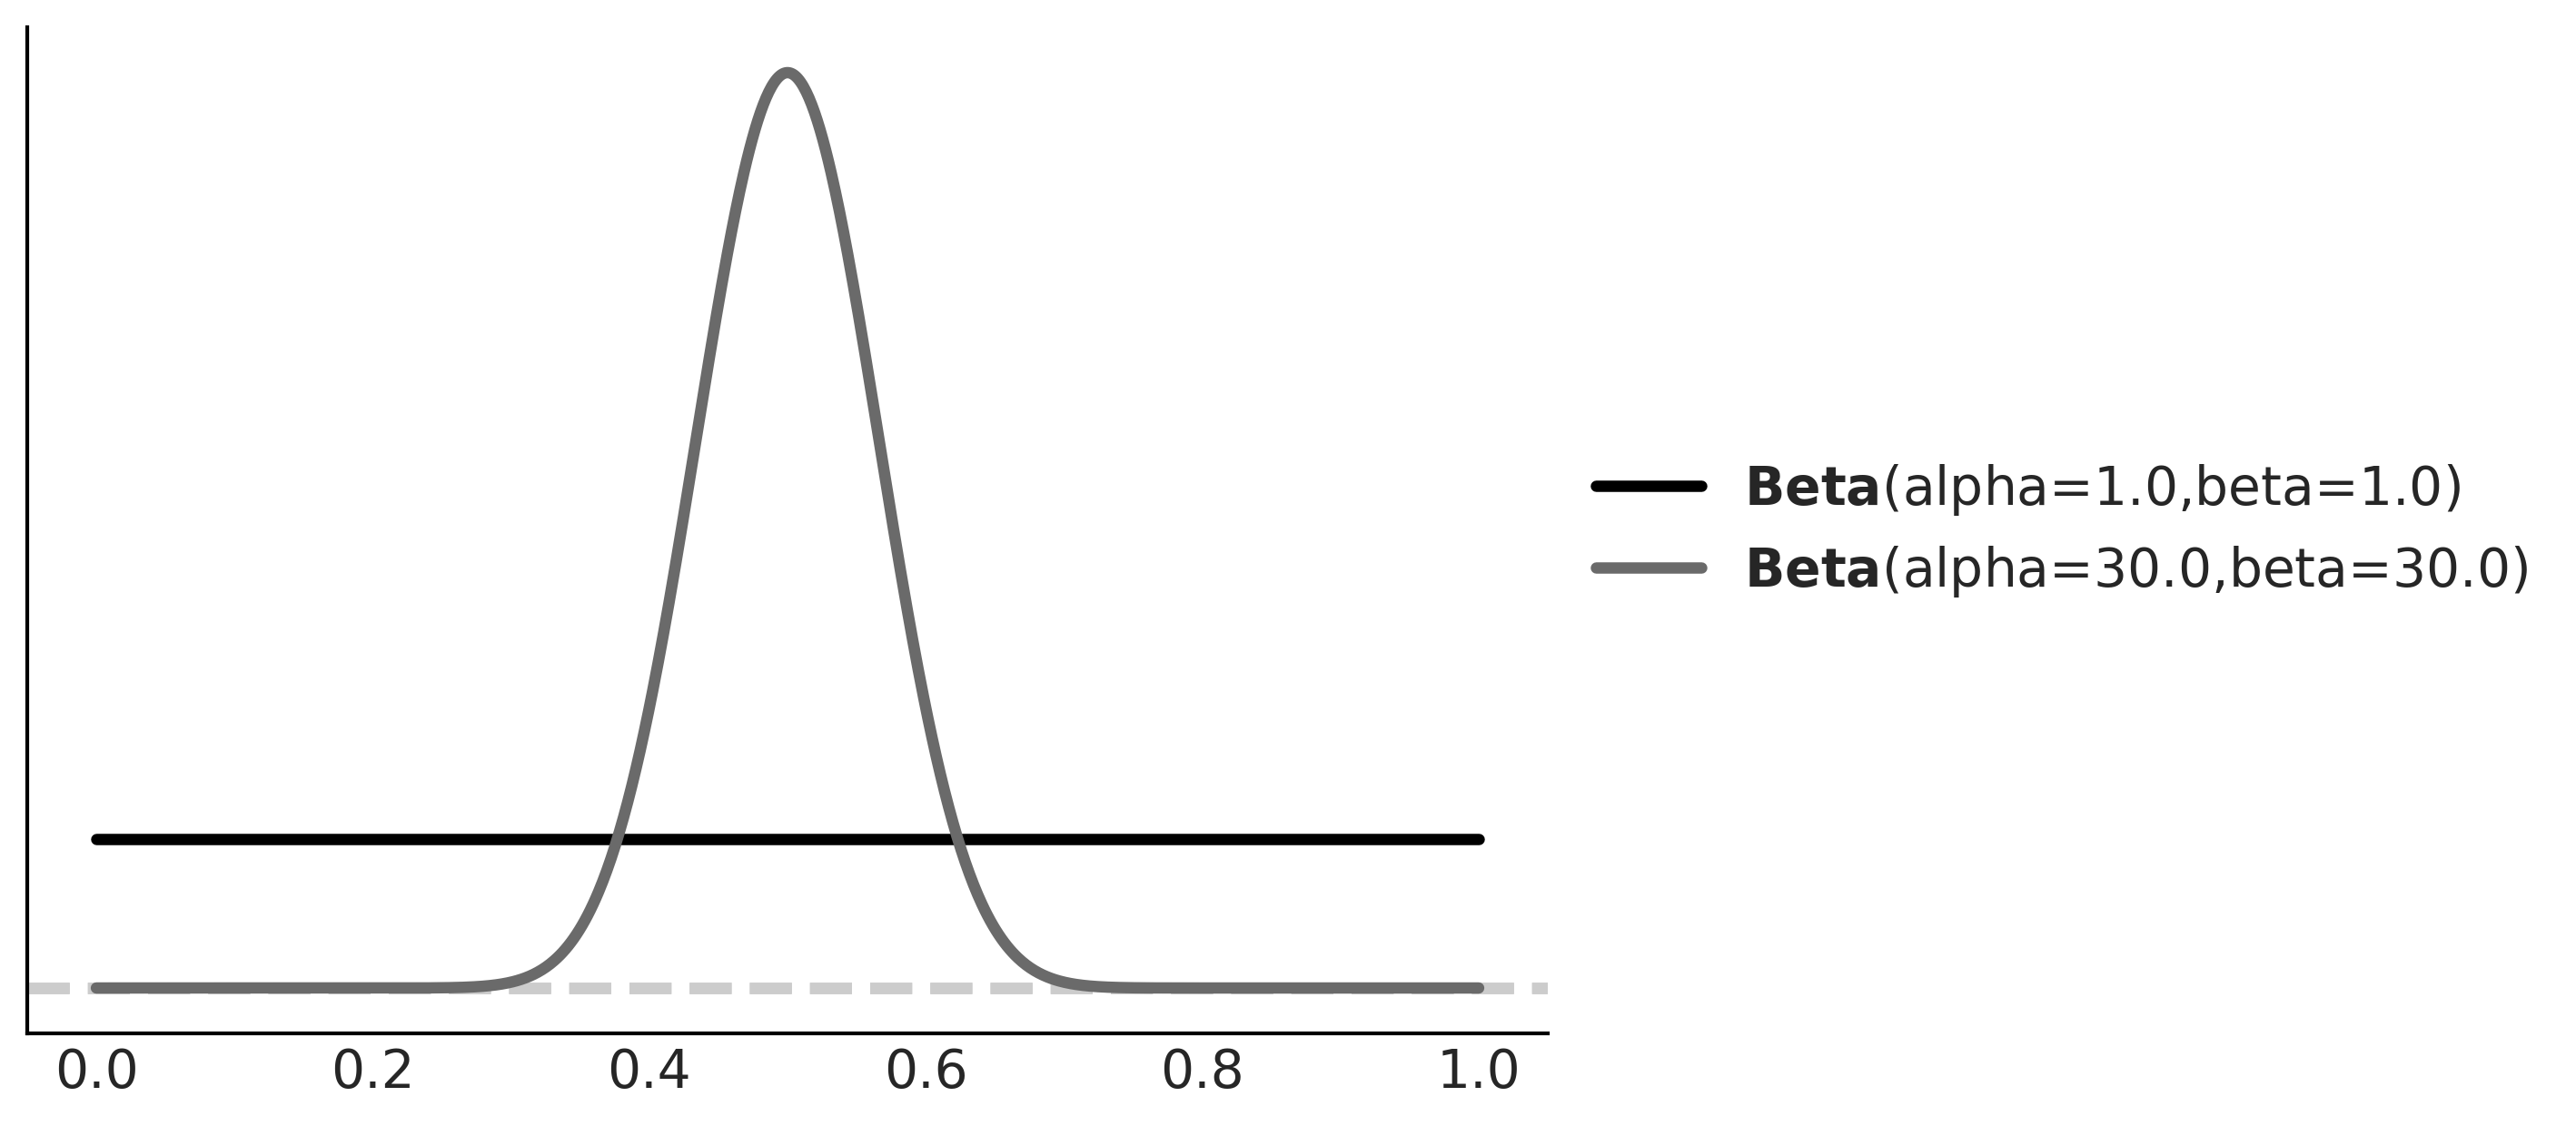

In [21]:
with plt.rc_context({"lines.linewidth": 3}):
    for a, b in priors:
        ax = pz.Beta(a, b).plot_pdf()
plt.savefig("../fig/beta-prior.png")

In [22]:
models = []
idatas = []
for alpha, beta in priors:
    with pm.Model() as model:
        a = pm.Beta("a", alpha, beta)
        yl = pm.Bernoulli("yl", a, observed=y)
        idata = pm.sample_smc(random_seed=42)
        models.append(model)
        idatas.append(idata)

BF_smc = np.exp(
    idatas[1].sample_stats["log_marginal_likelihood"].mean()
    - idatas[0].sample_stats["log_marginal_likelihood"].mean()
)
np.round(BF_smc).item()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


5.0

In [23]:
df0 = az.summary(idatas[0], var_names="a", kind="stats").round(2)
df1 = az.summary(idatas[1], var_names="a", kind="stats").round(2)
# pd.concat([df0, df1], axis=0).set_index([["uniform", "peaked"]]).to_markdown()
pd.concat([df0, df1], axis=0).set_index([["uniform", "peaked"]])

,mean,sd,hdi_3%,hdi_97%
uniform,0.5,0.05,0.40,0.59
peaked,0.5,0.04,0.42,0.57


In [24]:
ppc_0 = pm.sample_posterior_predictive(idatas[0], model=models[0], random_seed=4591).posterior_predictive
ppc_1 = pm.sample_posterior_predictive(idatas[1], model=models[1], random_seed=4591).posterior_predictive

Sampling: [yl]


Sampling: [yl]


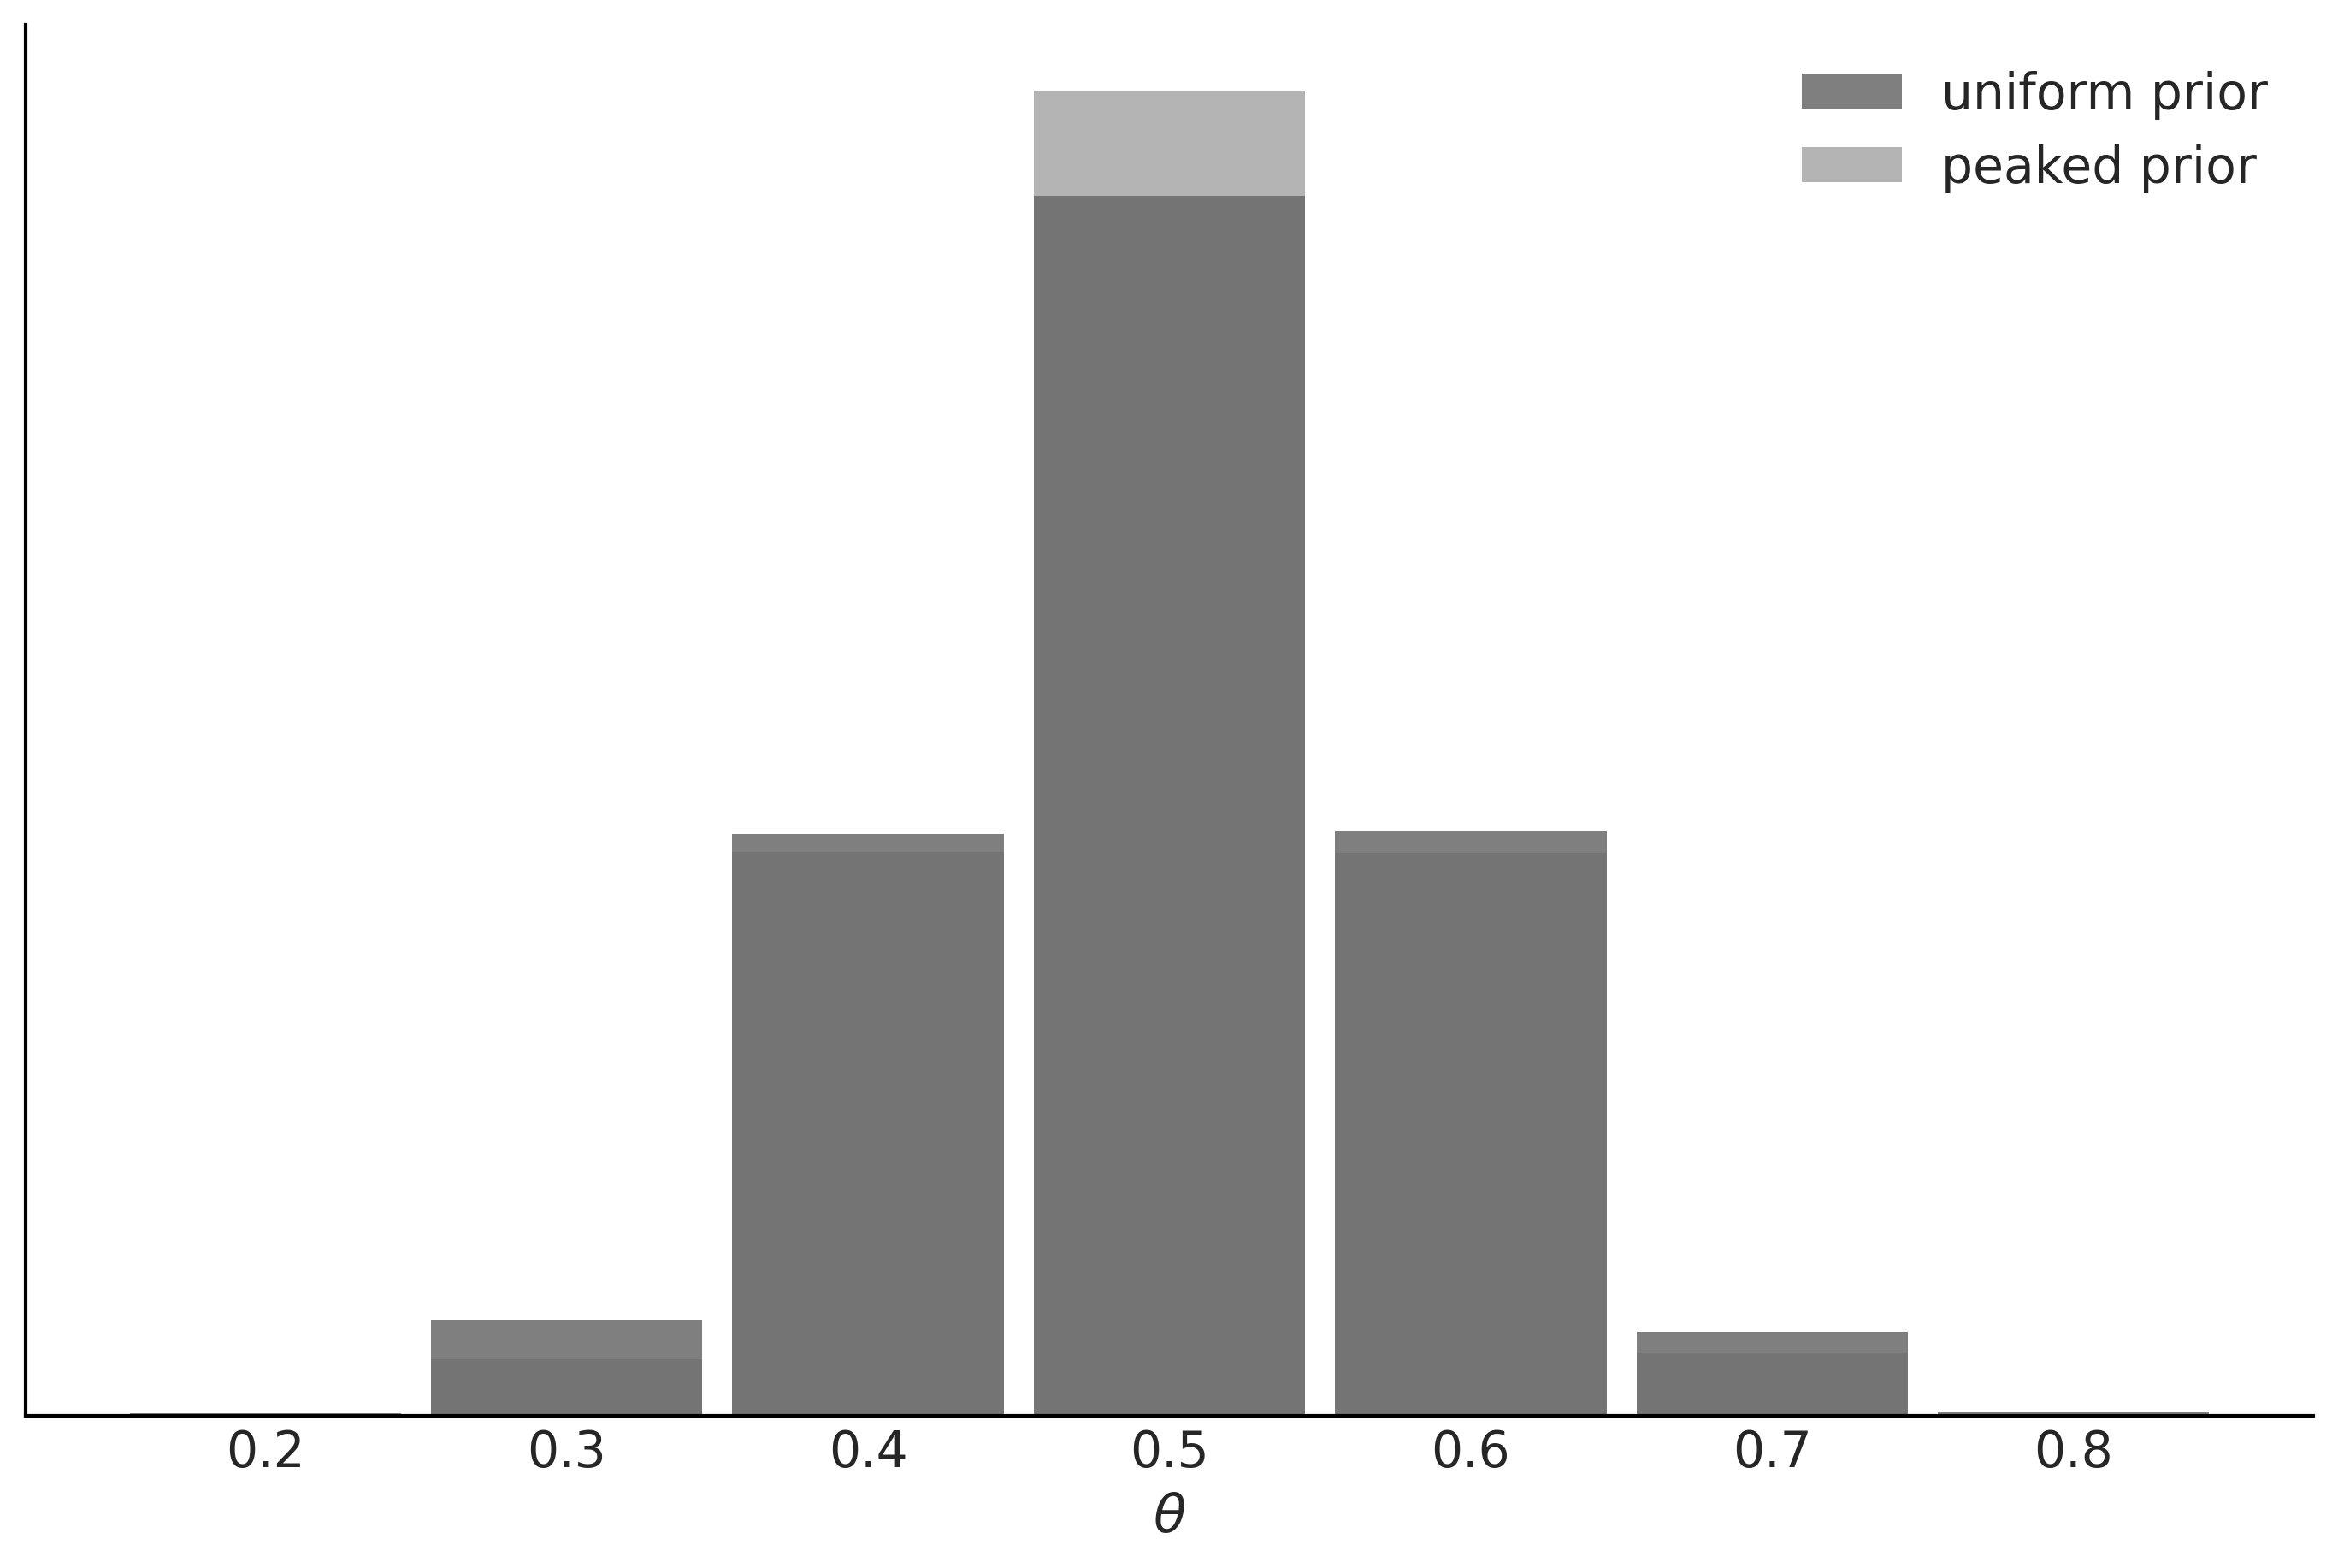

In [25]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.2, 0.8, 8)
ax = az.plot_dist(
    ppc_0["yl"].mean("yl_dim_2"),
    label="uniform prior",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)
ax = az.plot_dist(
    ppc_1["yl"].mean("yl_dim_2"),
    label="peaked prior",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("$\\theta$")
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([])
plt.savefig("../fig/beta-ppc.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [a, yl]


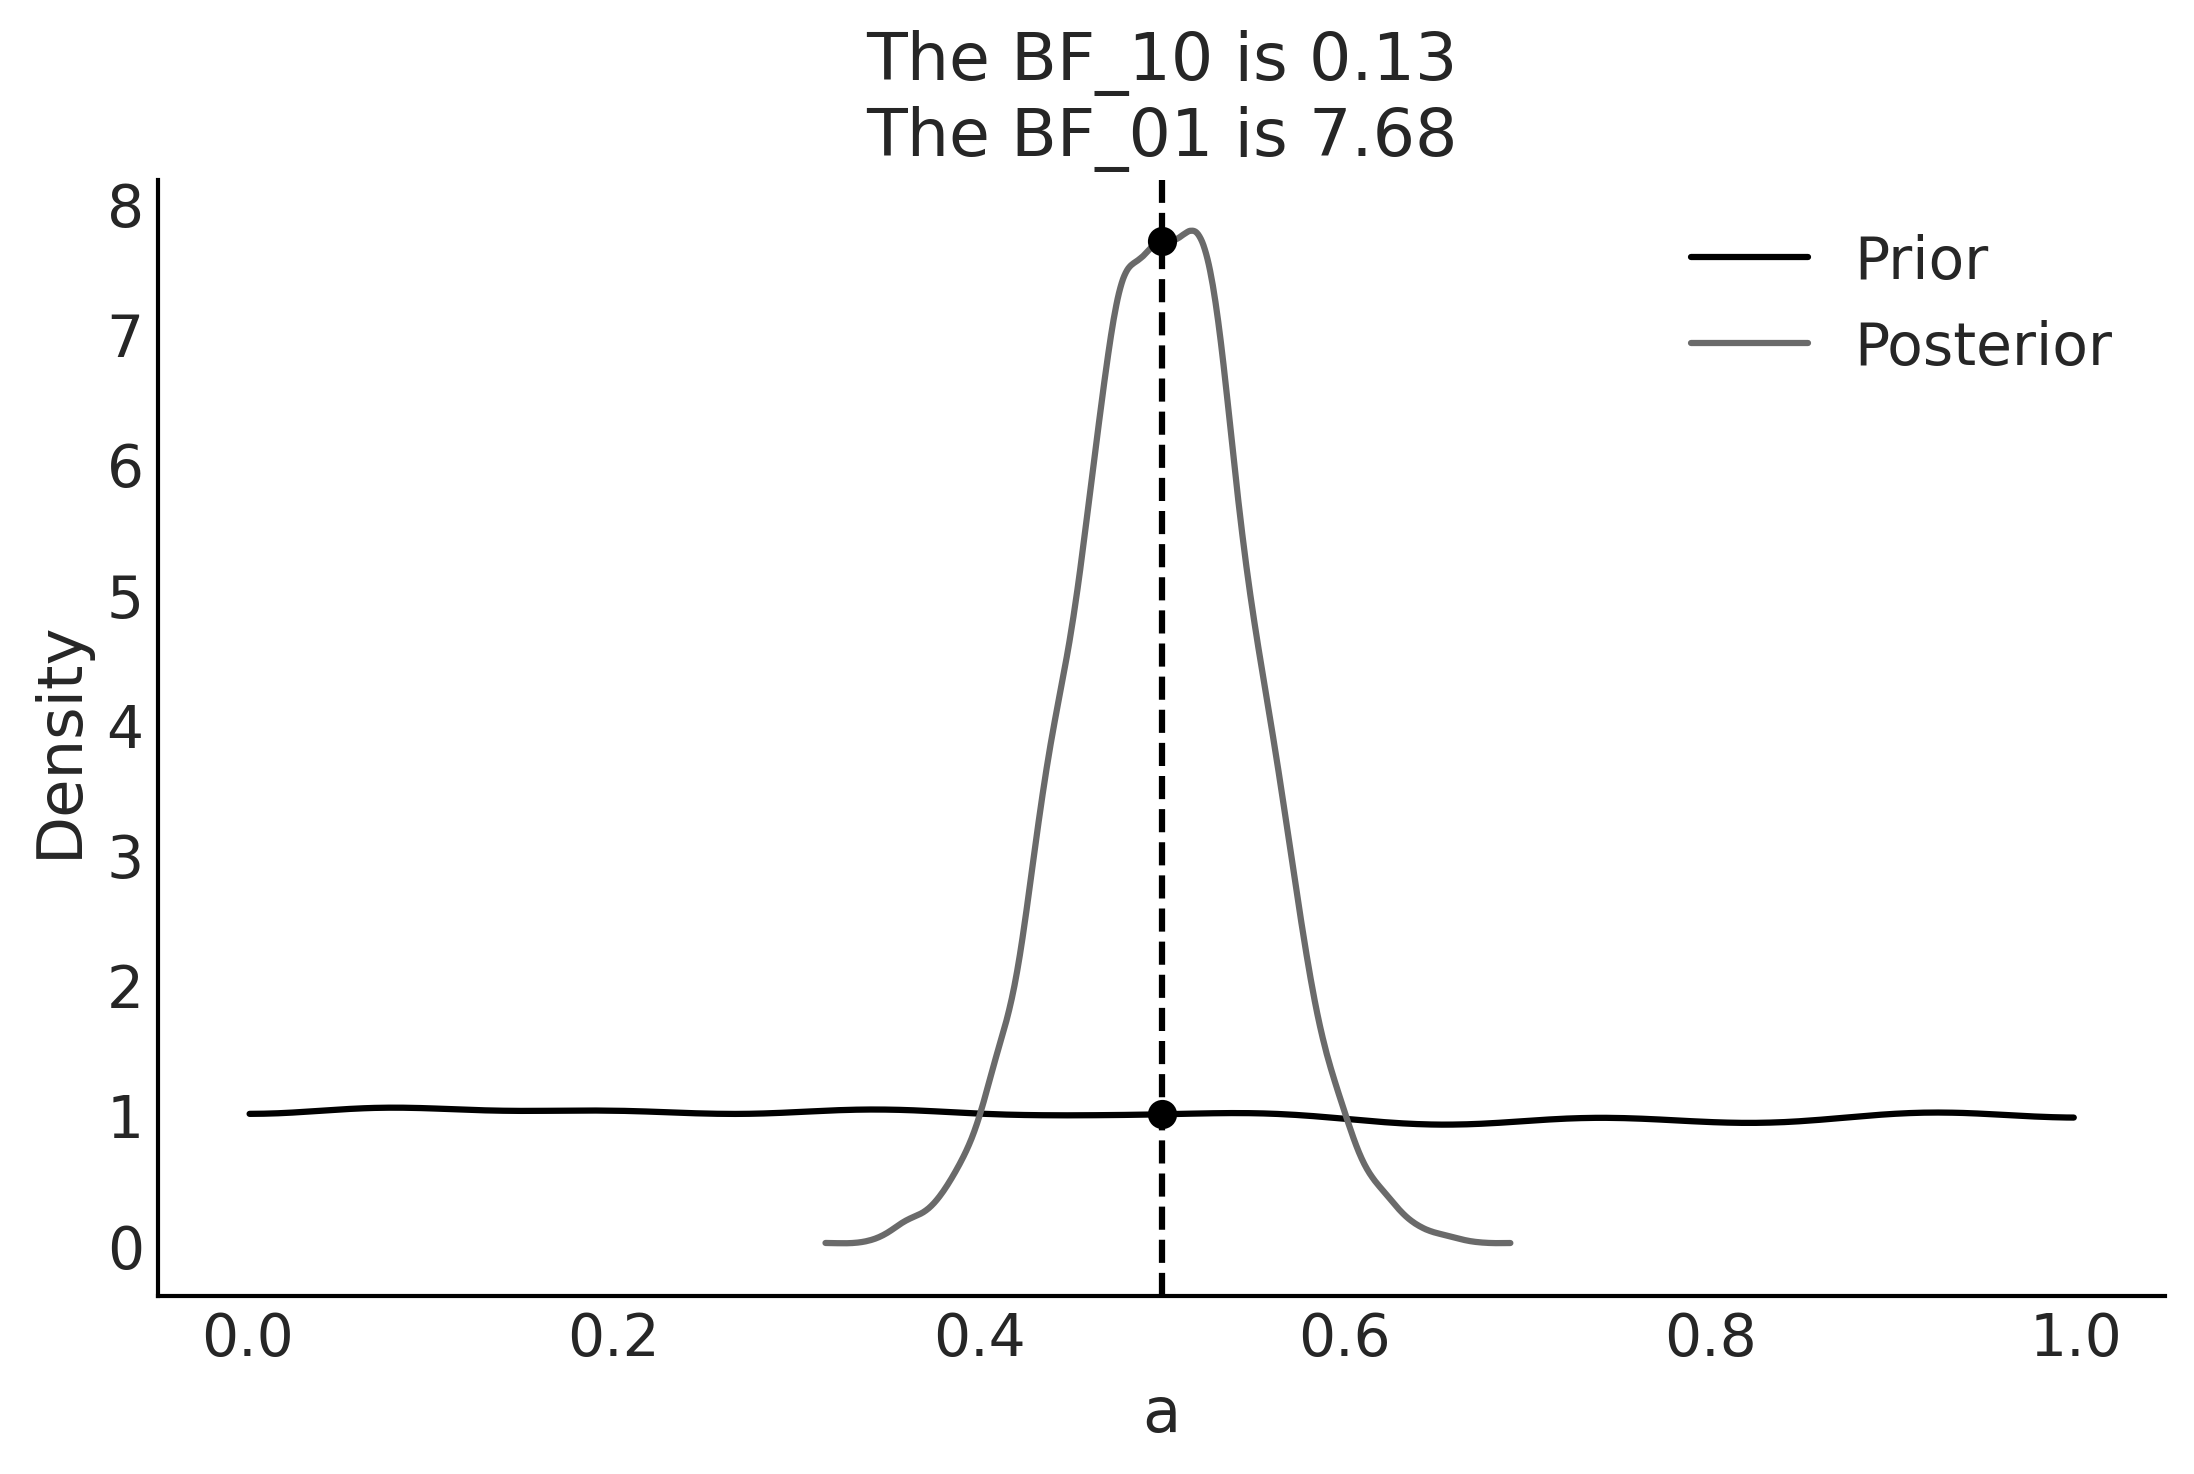

In [26]:
with pm.Model() as model_uni:
    a = pm.Beta("a", 1, 1)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_uni = pm.sample(2000, random_seed=42)
    idata_uni.extend(pm.sample_prior_predictive(8000, random_seed=4591))

az.plot_bf(idata_uni, var_name="a", ref_val=0.5)
plt.savefig("../fig/beta-bf.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [a, yl]


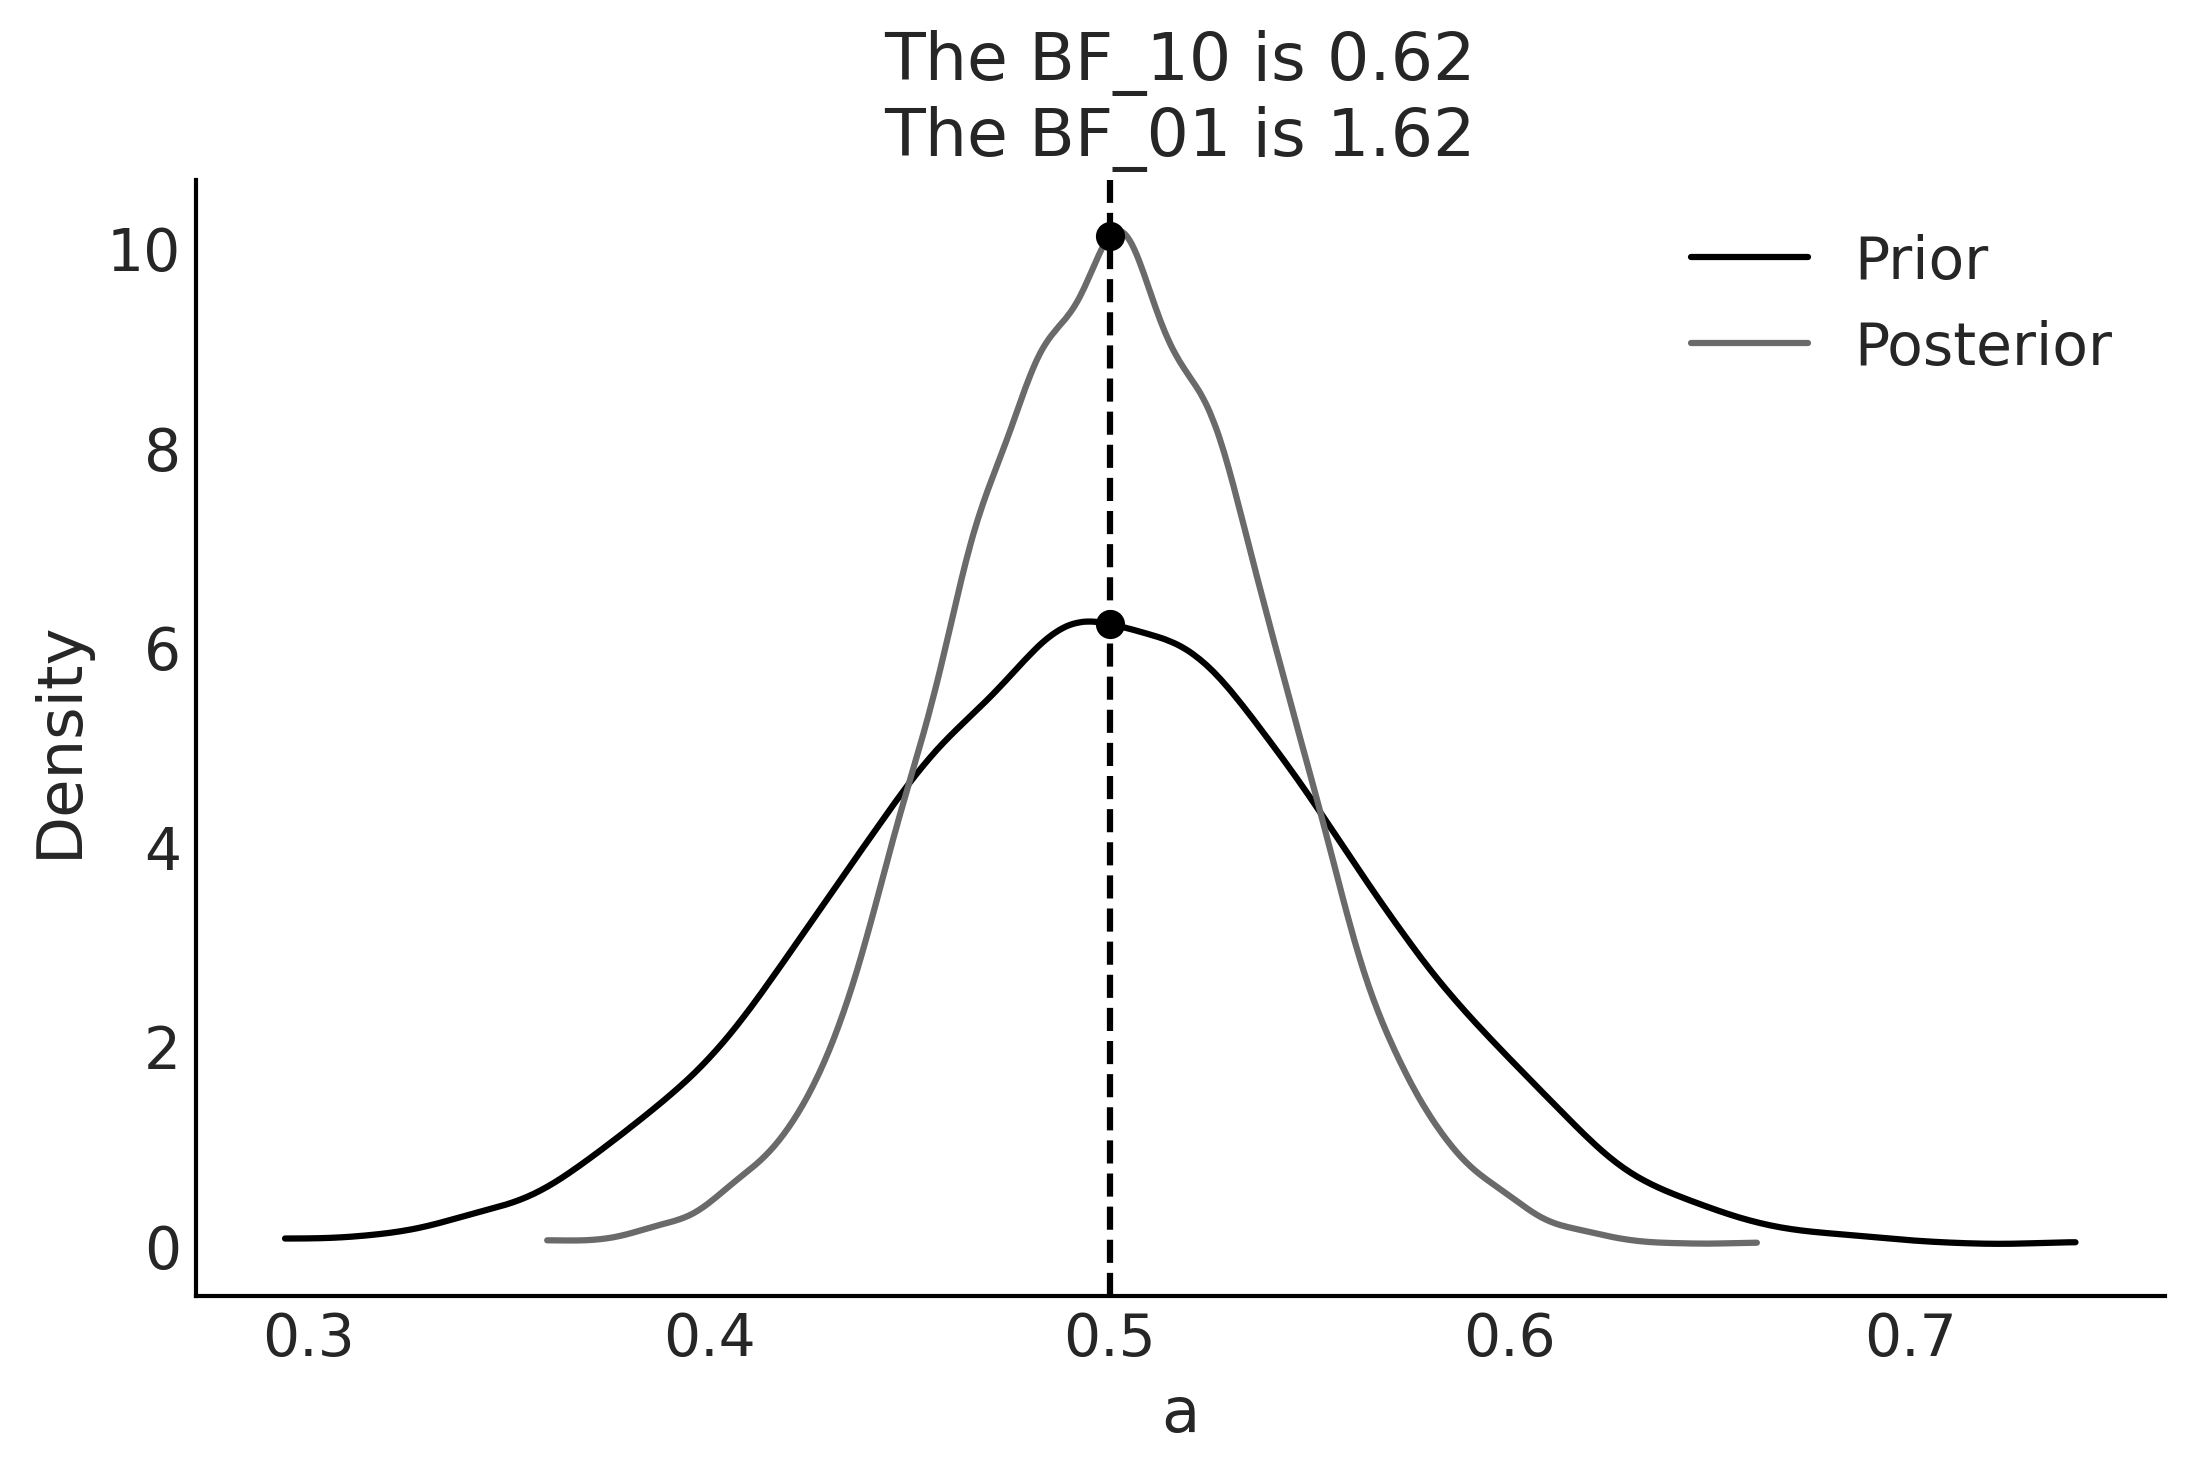

In [27]:
with pm.Model() as model_conc:
    a = pm.Beta("a", 30, 30)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_conc = pm.sample(2000, random_seed=42)
    idata_conc.extend(pm.sample_prior_predictive(8000, random_seed=4591))

az.plot_bf(idata_conc, var_name="a", ref_val=0.5)
plt.savefig("../fig/beta-bf2.png")